# Introdução ao Projeto 2 - Ciência dos dados 2021.2
### Autores: Rafael Niccheri, Larissa Jordana e Luis Antonio Bordignon

O projeto propõe a criação de um classificador - modelo de classificação ou de regressão - capaz de prever uma variável target ou uma variável contínua. 

O primeiro passo do projeto foi encontrar uma base de dados adequada. O site [Taggle](https://www.kaggle.com/adityakadiwal/water-potability), que contém inúmeras bases de dados, contém informações sobre a potabilidade da água com base em suas propriedades e elementos nela contidos - que será explorada e estudada neste projeto.

Desse modo, a variável target é Potability (potabilidade da água), e as variáveis feature são todas as outras colunas presentes na base de dados, como pH, Hardness e Turbudity. 

Como a utilização de uma base de dados cuja variável target é qualitativa, e não quantitativa, a decisão tomada foi de fazer modelos de classificação, visto que são mais adequados pra esse tipo de variável.

In [38]:
from scipy.stats import norm, expon, poisson as pois, binom, uniform as uni
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split as tts
from sklearn.ensemble import RandomForestClassifier as RandomForestC, GradientBoostingClassifier as GradientBoostingC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix as cm, classification_report, precision_score, plot_roc_curve, plot_precision_recall_curve, balanced_accuracy_score, roc_auc_score, accuracy_score, recall_score
import statsmodels.api as sm
from statsmodels.api import Logit
from tqdm.notebook import tqdm
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

In [39]:
css = '<style>.output {flex-direction: row;}</style>'
HTML(css)
pd.set_option('display.min_rows', 99999)

In [40]:
# Base de dados
df_agua = pd.read_csv('DataBase/water_potability.csv')
df_agua.head(11)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
5,5.584087,188.313324,28748.687739,7.544869,326.678363,280.467916,8.399735,54.917862,2.559708,0
6,10.223862,248.071735,28749.716544,7.513408,393.663396,283.651634,13.789695,84.603556,2.672989,0
7,8.635849,203.361523,13672.091764,4.563009,303.309771,474.607645,12.363817,62.798309,4.401425,0
8,NaN,118.988579,14285.583854,7.804174,268.646941,389.375566,12.706049,53.928846,3.595017,0
9,11.180284,227.231469,25484.508491,9.077200,404.041635,563.885481,17.927806,71.976601,4.370562,0


# Apresentação da análise
O objetivo da análise é entender a distribuição e relação das propriedades da água, e descobrir se eles se relacionam de alguma maneira e, caso positivo, como essa interação acontece. Principalmente, a meta a ser alcançada é definir com uma determinada precisão se a água estudada é própria para consumo ou não, de acordo com sua potabilidade.



# Vendo a correlação antes de alterar algo

In [41]:
# Correlação 
corr_bruto = pd.DataFrame.from_dict({k: {i: df_agua[k].corr(df_agua[i]) for i in list(df_agua)} for k in list(df_agua)})
corr_bruto

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
ph,1.000000,0.082096,-0.089288,-0.034350,0.018203,0.018614,0.043503,0.003354,-0.039057,-0.003556
Hardness,0.082096,1.000000,-0.046899,-0.030054,-0.106923,-0.023915,0.003610,-0.013013,-0.014449,-0.013837
Solids,-0.089288,-0.046899,1.000000,-0.070148,-0.171804,0.013831,0.010242,-0.009143,0.019546,0.033743
Chloramines,-0.034350,-0.030054,-0.070148,1.000000,0.027244,-0.020486,-0.012653,0.017084,0.002363,0.023779
Sulfate,0.018203,-0.106923,-0.171804,0.027244,1.000000,-0.016121,0.030831,-0.030274,-0.011187,-0.023577
Conductivity,0.018614,-0.023915,0.013831,-0.020486,-0.016121,1.000000,0.020966,0.001285,0.005798,-0.008128
Organic_carbon,0.043503,0.003610,0.010242,-0.012653,0.030831,0.020966,1.000000,-0.013274,-0.027308,-0.030001
Trihalomethanes,0.003354,-0.013013,-0.009143,0.017084,-0.030274,0.001285,-0.013274,1.000000,-0.022145,0.007130
Turbidity,-0.039057,-0.014449,0.019546,0.002363,-0.011187,0.005798,-0.027308,-0.022145,1.000000,0.001581
Potability,-0.003556,-0.013837,0.033743,0.023779,-0.023577,-0.008128,-0.030001,0.007130,0.001581,1.000000


# Verificando se faltam dados

In [42]:
df_agua.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

# Como tem quase 1000 dados de sulfato faltando, é interessante analisar um pouco mais...


In [43]:
# Comparação da correlação da quantidade de sulfato com uma análise binária de valores nulos
pd.DataFrame.from_dict({'Sulfato_na': {i: df_agua['Sulfate'].isna().corr(df_agua[i]) for i in list(df_agua)}, 'Sulfato': {i: df_agua['Sulfate'].corr(df_agua[i]) for i in list(df_agua)}})

,Sulfato_na,Sulfato
ph,-0.003380,0.018203
Hardness,0.008482,-0.106923
Solids,-0.010554,-0.171804
Chloramines,0.003452,0.027244
Sulfate,NaN,1.000000
Conductivity,0.014941,-0.016121
Organic_carbon,-0.023424,0.030831
Trihalomethanes,0.011342,-0.030274
Turbidity,-0.002739,-0.011187
Potability,-0.017148,-0.023577


In [44]:
# Em qual intervalo de quantidade de sulfato tem mais água potável? 
df_agua.groupby(pd.cut(df_agua["Sulfate"], [100, 200, 300, 400, 500])).sum()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
Sulfate,,,,,,,,,,
"(100, 200]",41.217291,1390.849069,2.136597e+05,62.334002,1058.232554,2714.941131,65.089762,433.041204,24.160863,6
"(200, 300]",2738.399672,93140.327891,1.150551e+07,3261.478099,129514.667820,199508.669879,6528.501431,30580.952958,1857.332158,231
"(300, 400]",11422.639189,370294.373365,4.044337e+07,13434.888267,644151.555619,801702.845009,27148.638982,117636.689146,7457.102608,675
"(400, 500]",787.115474,24727.104161,2.891779e+06,1003.752214,58046.106651,57769.857092,2006.923301,8664.492215,561.519393,73


In [45]:
# Filtrando o que é potável 
Sulf_NaN = df_agua.loc[df_agua['Sulfate'].isna()]; Sulf_NaN_Pot = Sulf_NaN['Potability'].sum()
print(f' {Sulf_NaN_Pot * 100 / Sulf_NaN.Sulfate.size}% de NaN (Sulfato) são potáveis')
print(f' {Sulf_NaN.Sulfate.size * 100 / df_agua.Sulfate.size}% das linhas não tem dados para Sulfato')

 37.516005121638926% de NaN (Sulfato) são potáveis
 23.84004884004884% das linhas não tem dados para Sulfato


In [46]:
# Médias de sulfeto nas águas potáveis e não potáveis - todas as amostras
sulfato0 = df_agua.loc[df_agua['Potability']==0]; sulfato1 = df_agua.loc[df_agua['Potability']==1]
print(f"Média de sulfato em águas nao potáveis {sulfato0['Sulfate'].sum() / sulfato0['Sulfate'].size} e em águas potáveis {sulfato1['Sulfate'].sum() / sulfato1['Sulfate'].size}, considerando todas as amostras")


Média de sulfato em águas nao potáveis 252.84888751942893 e em águas potáveis 256.3211935682008, considerando todas as amostras


In [47]:
#  Médias de sulfeto nas águas potáveis e não potáveis - apenas amostras com dados para sulfato
sulfato_semNaN = df_agua[['Sulfate', 'Potability']].dropna()
sulfato0_semNaN = sulfato_semNaN.loc[sulfato_semNaN['Potability']==0]; sulfato1_semNaN = sulfato_semNaN.loc[sulfato_semNaN['Potability']==1]

print(f"Média de sulfato em águas não potáveis {sulfato0_semNaN['Sulfate'].sum() / sulfato0_semNaN['Sulfate'].size} e em águas potáveis {sulfato1_semNaN['Sulfate'].sum() / sulfato1_semNaN['Sulfate'].size}, considerando somente as amostras com dados para sulfato")

Média de sulfato em águas não potáveis 334.5642895786881 e em águas potáveis 332.56699023366554, considerando somente as amostras com dados para sulfato


# Considerações finais sobre a análise inicial

Na primeira parte da análise de dados, é possível entender a correlação entre as propriedades da água, e como alguns dados são mais independentes do que outros.

Depois, foi realizada a busca por possíveis faltas de dados, que se demonstrou eficaz em evindenciar que muita informação sobre pH, Sulfate e Trihalomethanes não estão presentes no banco de dados. Como, especialmente, o Sulfate apresentou a maior lacuna de dados entre as colunas, entendeu-se como necessário fazer uma análise mais profunda. A partir dessa análise extra, determinou-se que as lacunas serão preenchidas com a média dos dados. Para a água não potável, será a média de sulfato na água não potável, sendo essa relação válida para a água potável.

Com base nos dados gerados nesse primeiro estudo, Foi notado que as médias de Sulfato em águas potáveis e em águas não potáveis, considerando todas as amostras, eram muito parecidas. Também, as amostras considerando apenas os rescpectivos dados de sua potabilidade também são próximas. Com base nisso, conclui-se que substituir os dados inexistentes pela média de sua classificação é de suma importância. O mesmo procedimento foi realizado para as outras colunas com lacuna de dados. No entando, neste momento, foi decidido que realizar essa substituiçãourua afetar os outliers, visto que aumenta a concentração de dados em torno de um número. Os outliers, que também podem ser definidos por uma série de outros nomes - como dados discrepantes, pontos fora da curva, observações fora do comum, anomalias, valores atípicos, entre outros - são úteis para analisar se existem muitos dados que estão fora do padrão. Em um contexto de machine learning, não se pode dizer que outliers sempre atrapalham ou sempre ajudam o modelo a melhorar sua performance, mas a decisão de remover ou manter os outlier sempre tem um impacto e, para que esse impacto seja condizente com o os dados coletados, é nessessário calcular esse antes de concretizar qualquer alteração na base de dados.

Uma das melhores e mais utilizadas formas de encontrar os outliers é através de gráficos chamados de BoxPlot. Isso acontece porque, ao plotar este tipo de gráfico, ele deixa claro a região em que se espera encontrar a maioria dos dados ao tomar uso dos quartis para definir os limites inferior e superior de que se considera rozoável.

# Olhando Outliers

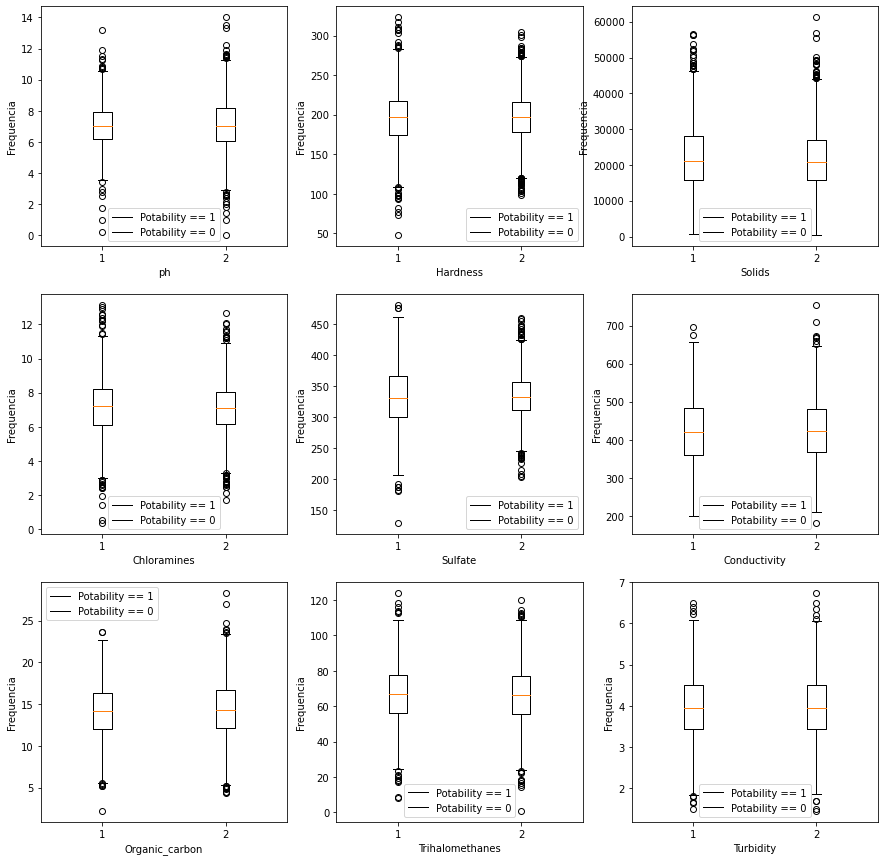

In [48]:
# Vizualizando
plt.figure(figsize=(15, 15), num='corr_ajustada sem pot')
n = 1
for i in ['ph','Hardness','Solids','Chloramines','Sulfate','Conductivity','Organic_carbon','Trihalomethanes','Turbidity']:
    plt.subplot(3, 3, n)
    n+=1
    plt.boxplot([df_agua.loc[df_agua['Potability']==1][i].dropna(), df_agua.loc[df_agua['Potability']==0][i].dropna()])
    plt.xlabel(i)
    plt.ylabel('Frequencia')
    plt.legend(('Potability == 1', 'Potability == 0'))
plt.show()

In [49]:
# Divindo os quantis
Q1 = df_agua.quantile(0.25)
Q3 = df_agua.quantile(0.75)
IQR = Q3 - Q1
Outliers = ((df_agua < (Q1 - 1.5 * IQR)) | (df_agua > (Q3 + 1.5 * IQR))).sum()
Outliers.sum()

366

# Com Outliers

In [50]:
# Utilizando as médias das colunas para preencher as informações faltando
df_agua1 = df_agua.copy()
df_agua1_1 = df_agua1.loc[df_agua1['Potability'] == 1]
df_agua1_0 = df_agua1.loc[df_agua1['Potability'] == 0]
for i in list(df_agua):
    df_agua1.loc[df_agua1[i] == 1] = df_agua1.loc[df_agua1[i] == 1].fillna(df_agua1.loc[df_agua1[i] == 1].mean())
    df_agua1.loc[df_agua1[i] == 0] = df_agua1.loc[df_agua1[i] == 0].fillna(df_agua1.loc[df_agua1[i] == 0].mean())
df_agua1.head(11)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,7.085378,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,334.564290,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,334.564290,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
5,5.584087,188.313324,28748.687739,7.544869,326.678363,280.467916,8.399735,54.917862,2.559708,0
6,10.223862,248.071735,28749.716544,7.513408,393.663396,283.651634,13.789695,84.603556,2.672989,0
7,8.635849,203.361523,13672.091764,4.563009,303.309771,474.607645,12.363817,62.798309,4.401425,0
8,7.085378,118.988579,14285.583854,7.804174,268.646941,389.375566,12.706049,53.928846,3.595017,0
9,11.180284,227.231469,25484.508491,9.077200,404.041635,563.885481,17.927806,71.976601,4.370562,0


# Sem Outliers

In [51]:
# Filtra os Outliers
df_agua1_Sout = df_agua1.copy()
for i in list(df_agua.columns)[:-1]:
    df_agua1_Sout = df_agua1_Sout[(df_agua1_Sout[i] >= (Q1[i] - 1.5 * IQR[i])) & (df_agua1_Sout[i] <= (Q3[i] + 1.5 * IQR[i]))]
df_agua1_Sout.head(11)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,7.085378,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,334.564290,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,334.564290,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
5,5.584087,188.313324,28748.687739,7.544869,326.678363,280.467916,8.399735,54.917862,2.559708,0
6,10.223862,248.071735,28749.716544,7.513408,393.663396,283.651634,13.789695,84.603556,2.672989,0
7,8.635849,203.361523,13672.091764,4.563009,303.309771,474.607645,12.363817,62.798309,4.401425,0
8,7.085378,118.988579,14285.583854,7.804174,268.646941,389.375566,12.706049,53.928846,3.595017,0
10,7.360640,165.520797,32452.614409,7.550701,326.624353,425.383419,15.586810,78.740016,3.662292,0


In [52]:
# Verificando se faltam dados
df_agua1.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

In [53]:
# Ajustando a correlação
corr_ajustada = pd.DataFrame.from_dict({k: {i: df_agua1[k].corr(df_agua1[i]) for i in list(df_agua1)} for k in list(df_agua1)})
corr_ajustada

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
ph,1.000000,0.075878,-0.081887,-0.031827,0.014785,0.017205,0.040092,0.003009,-0.036211,-0.003848
Hardness,0.075878,1.000000,-0.046899,-0.030054,-0.092718,-0.023915,0.003610,-0.012718,-0.014449,-0.013837
Solids,-0.081887,-0.046899,1.000000,-0.070148,-0.149809,0.013831,0.010242,-0.008849,0.019546,0.033743
Chloramines,-0.031827,-0.030054,-0.070148,1.000000,0.023490,-0.020486,-0.012653,0.016615,0.002363,0.023779
Sulfate,0.014785,-0.092718,-0.149809,0.023490,1.000000,-0.014196,0.027403,-0.025797,-0.009523,-0.026957
Conductivity,0.017205,-0.023915,0.013831,-0.020486,-0.014196,1.000000,0.020966,0.001238,0.005798,-0.008128
Organic_carbon,0.040092,0.003610,0.010242,-0.012653,0.027403,0.020966,1.000000,-0.012944,-0.027308,-0.030001
Trihalomethanes,0.003009,-0.012718,-0.008849,0.016615,-0.025797,0.001238,-0.012944,1.000000,-0.021540,0.007305
Turbidity,-0.036211,-0.014449,0.019546,0.002363,-0.009523,0.005798,-0.027308,-0.021540,1.000000,0.001581
Potability,-0.003848,-0.013837,0.033743,0.023779,-0.026957,-0.008128,-0.030001,0.007305,0.001581,1.000000


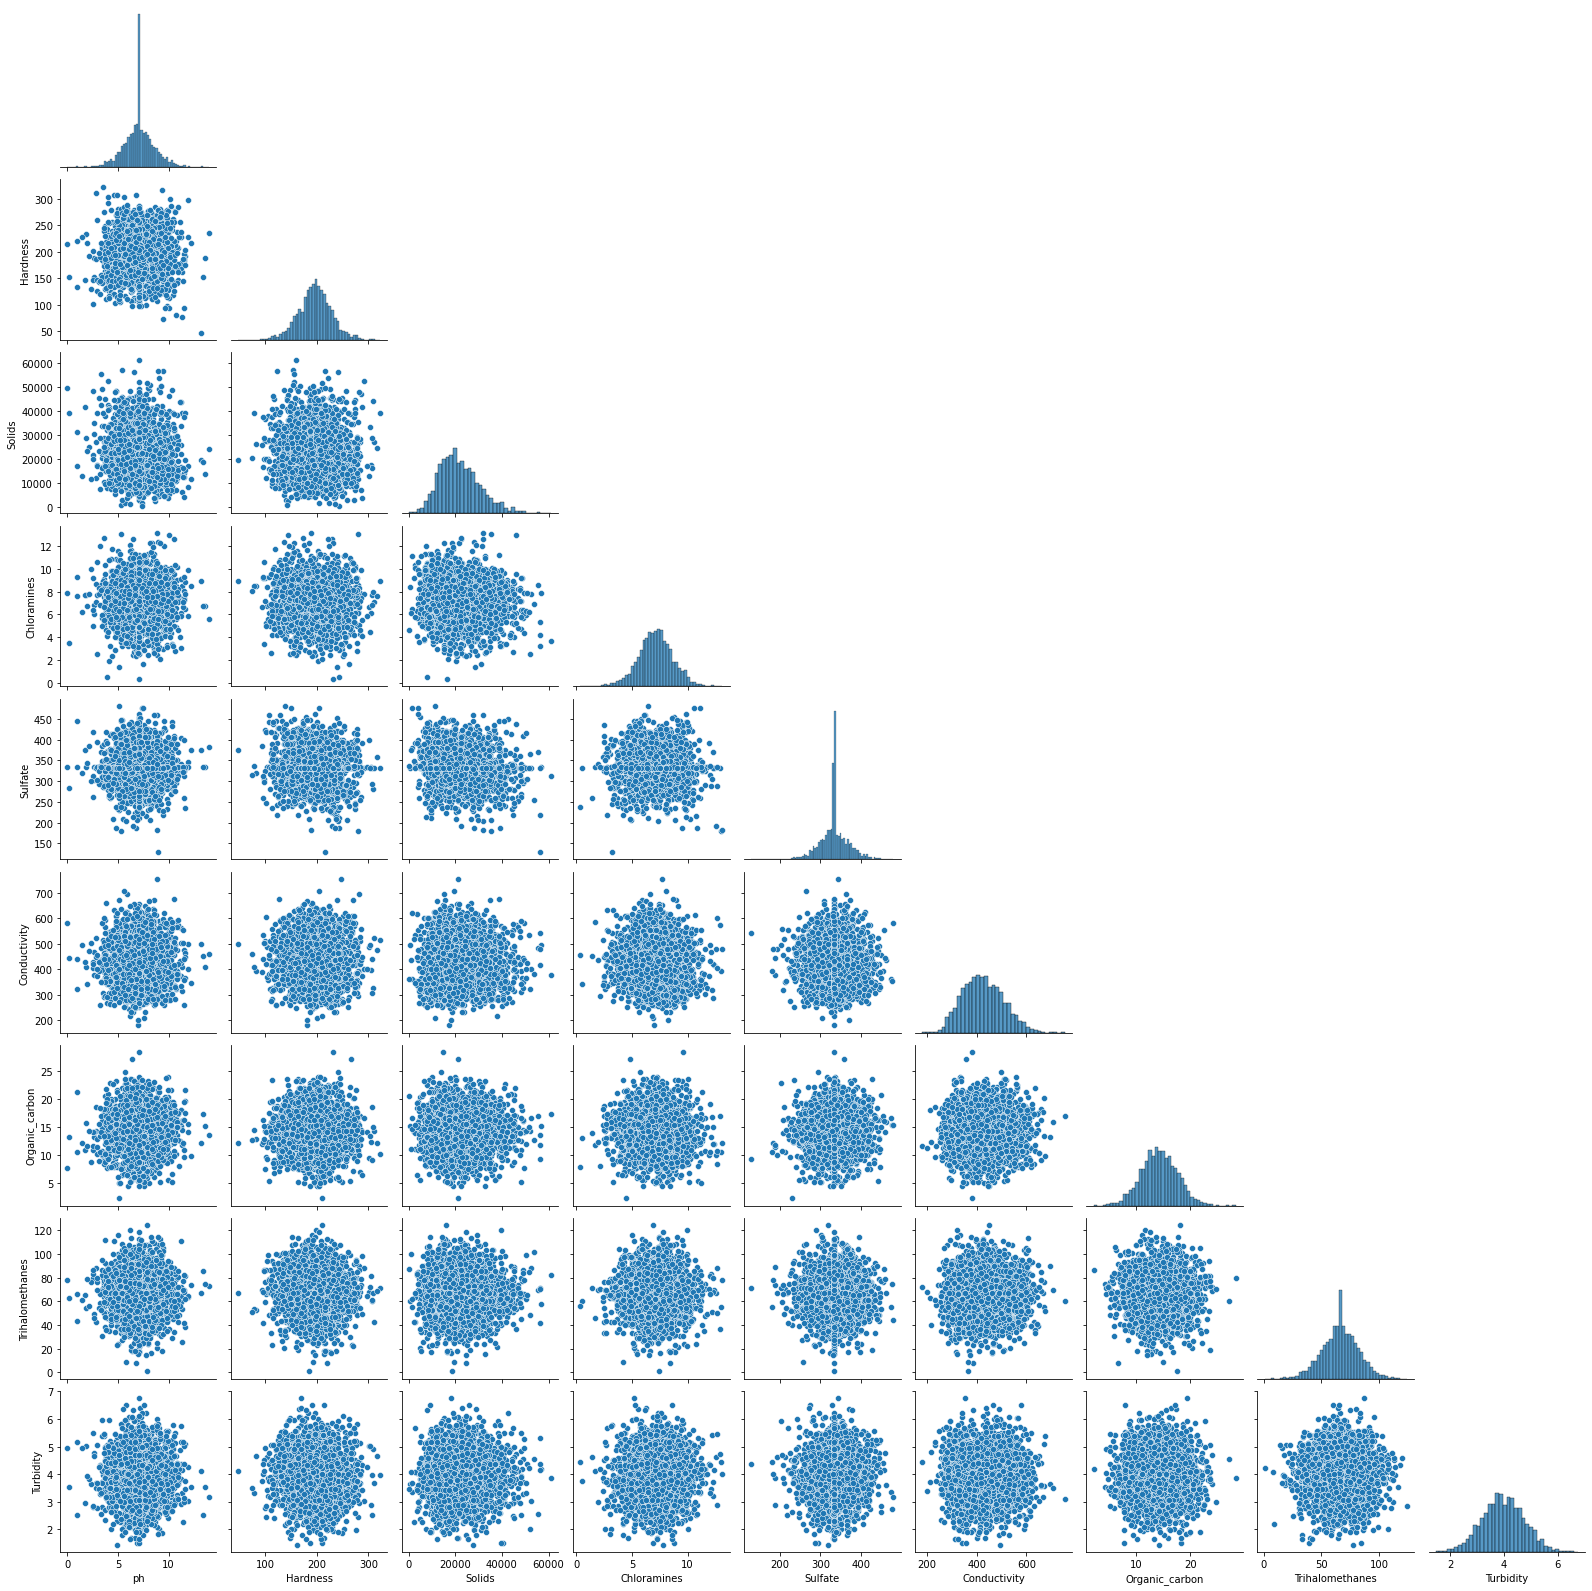

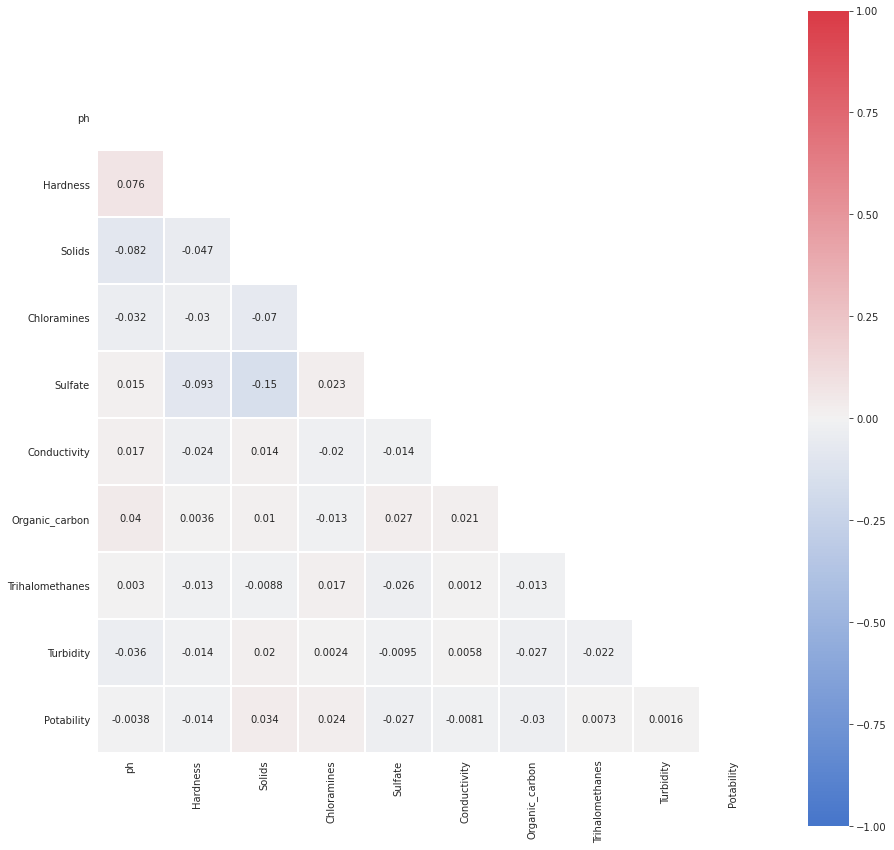

In [54]:
# Vizualizando a dispersão dos valores (correlacionando eles)
sns.pairplot(df_agua1[['ph','Hardness','Solids','Chloramines','Sulfate','Conductivity','Organic_carbon','Trihalomethanes','Turbidity']], corner=True)
plt.show(block=False)
mask = np.zeros_like(corr_ajustada)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 15), num='corr_ajustada sem pot')
    cmap = sns.diverging_palette(255, 10, as_cmap=True)
    sns.heatmap(corr_ajustada, vmin=-1, vmax=1, mask=mask, cmap=cmap, annot=True, square=True, linewidths=1)
plt.show(block=False)

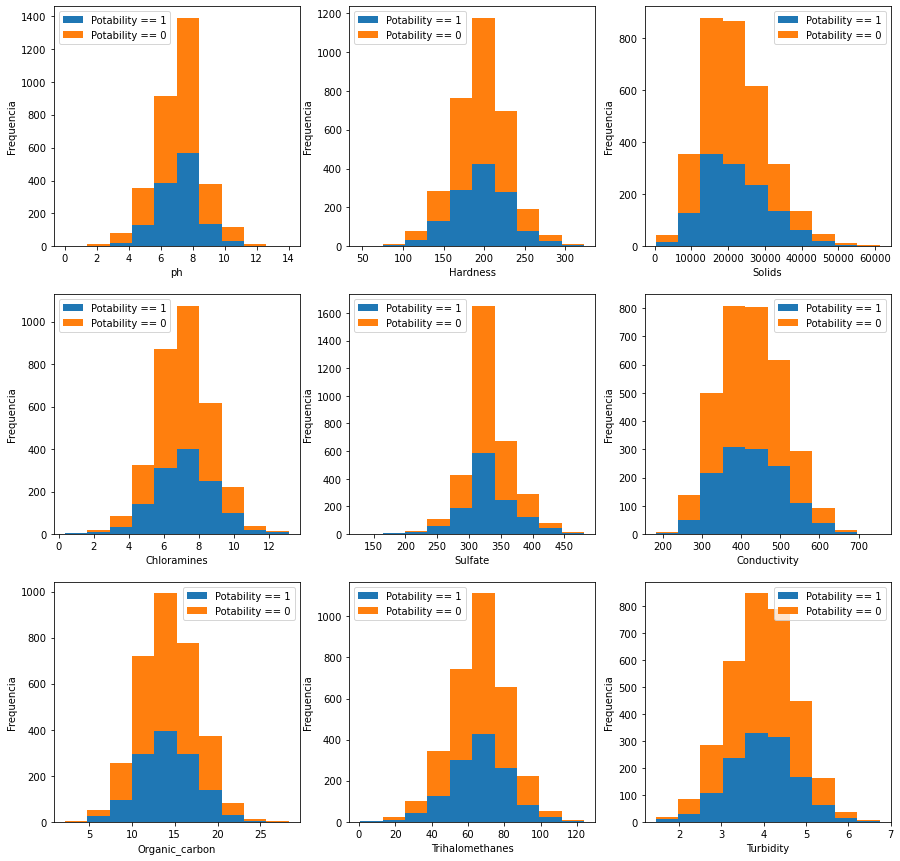

In [55]:
# Vizualizando ocorrência de potabilidade por faixa de valor de cada propriedade
plt.figure(figsize=(15, 15), num='corr_ajustada sem pot')
n = 1
for i in ['ph','Hardness','Solids','Chloramines','Sulfate','Conductivity','Organic_carbon','Trihalomethanes','Turbidity']:
    plt.subplot(3, 3, n)
    n+=1
    plt.hist([df_agua1.loc[df_agua1['Potability']==1][i], df_agua1.loc[df_agua1['Potability']==0][i]], stacked=True)
    plt.xlabel(i)
    plt.ylabel('Frequencia')
    plt.legend(('Potability == 1', 'Potability == 0'))
plt.show()

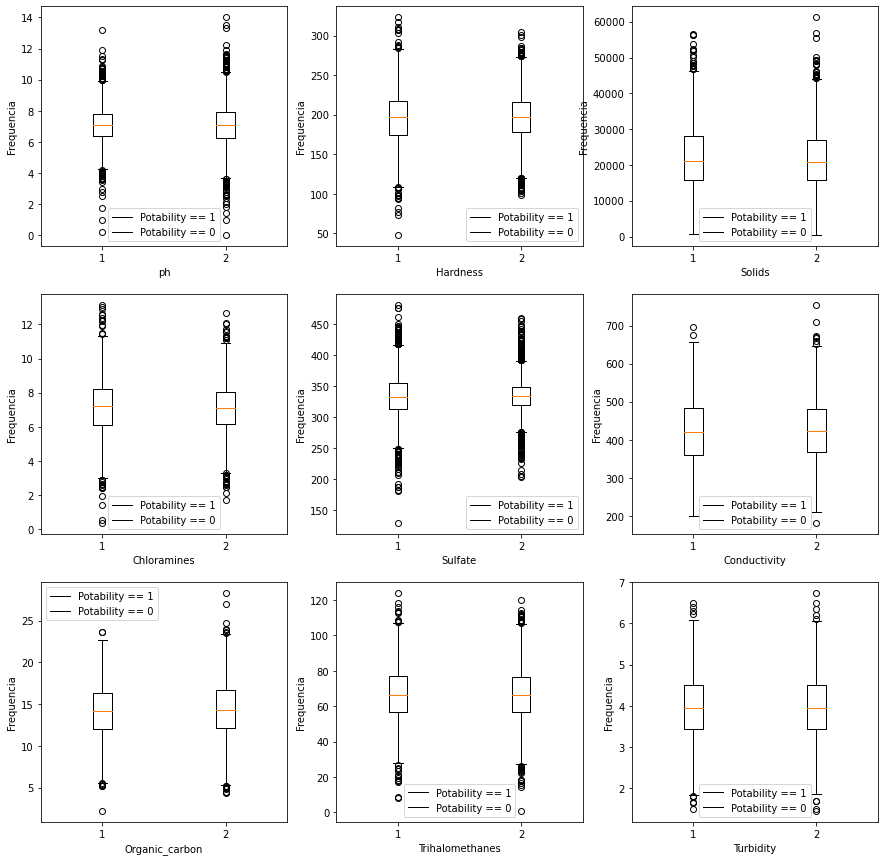

In [56]:
# Dispersão de valores com base na média
plt.figure(figsize=(15, 15), num='corr_ajustada sem pot')
n = 1
for i in ['ph','Hardness','Solids','Chloramines','Sulfate','Conductivity','Organic_carbon','Trihalomethanes','Turbidity']:
    plt.subplot(3, 3, n)
    n+=1
    plt.boxplot([df_agua1.loc[df_agua1['Potability']==1][i], df_agua1.loc[df_agua1['Potability']==0][i]])
    plt.xlabel(i)
    plt.ylabel('Frequencia')
    plt.legend(('Potability == 1', 'Potability == 0'))
plt.show()

In [57]:
# Detalhes das medidas de descrição - potável
df_agua1.loc[df_agua1['Potability'] == 1].describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,1278.000000,1278.000000,1278.000000,1278.000000,1278.000000,1278.000000,1278.000000,1278.000000,1278.000000,1278.0
mean,7.073783,195.800744,22383.991018,7.169338,332.566990,425.383800,14.160893,66.539684,3.968328,1.0
std,1.343952,35.547041,9101.010208,1.702988,41.865385,82.048446,3.263907,15.971941,0.780842,0.0
min,0.227499,47.432000,728.750830,0.352000,129.000000,201.619737,2.200000,8.175876,1.492207,1.0
25%,6.351824,174.330531,15668.985035,6.094134,313.052947,360.939023,12.033897,56.911186,3.430909,1.0
50%,7.073783,196.632907,21199.386614,7.215163,332.566990,420.712729,14.162809,66.539684,3.958576,1.0
75%,7.780068,218.003420,27973.236446,8.199261,354.807924,484.155911,16.356245,77.067457,4.509569,1.0
max,13.175402,323.124000,56488.672413,13.127000,481.030642,695.369528,23.604298,124.000000,6.494249,1.0


In [58]:
# Detalhes das medidas de descrição - não potável
df_agua1.loc[df_agua1['Potability'] == 0].describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,1998.000000,1998.000000,1998.000000,1998.000000,1998.000000,1998.000000,1998.000000,1998.000000,1998.000000,1998.0
mean,7.085378,196.733292,21777.490788,7.092175,334.564290,426.730454,14.364335,66.303555,3.965800,0.0
std,1.545489,31.057540,8543.068788,1.501045,31.941870,80.047317,3.334554,15.642622,0.780282,0.0
min,0.000000,98.452931,320.942611,1.683993,203.444521,181.483754,4.371899,0.738000,1.450000,0.0
25%,6.224046,177.823265,15663.057382,6.155640,319.354715,368.498530,12.101057,56.441831,3.444062,0.0
50%,7.085378,197.123423,20809.618280,7.090334,334.564290,422.229331,14.293508,66.303555,3.948076,0.0
75%,7.940697,216.120687,27006.249009,8.066462,348.316746,480.677198,16.649485,76.518849,4.496106,0.0
max,14.000000,304.235912,61227.196008,12.653362,460.107069,753.342620,28.300000,120.030077,6.739000,0.0


# Considerações finais sobre a análise *como um todo*


Tendo em vista a segunda parte da análise, assim como a própria análise como um todo é possível notar como alterar dados na base antes de decidir se tratar os outliers os afeta. Ao comparar os dois BoxPlots gerados, é possível notar o fenômeno explicado acima sobre o aumento na quantidade de outliers evidenciados pelo gráfico ao fazer alterações na base de dados. Vale notar também que, apesar de ter criado um novo dataframe sem os outliers no início da segunda parte da análise, toda a análise foi feita utilizando os dados com outliers. Também, ao analisar o pairplot e o heatmap plotados, juntamente com o dataframe de correlação ajustado, é possível perceber que fazer esse tipo de alteração na base de dados não afeta significativamente a correlação, ao contrário do que acontece com os outliers. Por fim, ao analisar os histogramas gerados, é notável que os dados de agua potável e não potável seguem o mesmo comportamento Isso sustenta a conclusão de que, na maioria das ocasiões, as análises feitas para uma classificação também vai ser verdadeira para a outra.


#  Iniciando modelos de classificação

# O que é um modelo de classificação?

O método de análise permite estimar o valor de uma determinada variável resposta (variável dependente) como função de outras variáveis preditoras (variáveis independentes).  Nele, a estimação dos mínimos quadrados ordinários – MQO é uma técnica de otimização dos quadrados do erro da regressão. 
 
Apesar de esse método de análise ser muito eficaz, é preciso haver cuidado, visto que os resultados tendem a ser enviesados. Isso acontece porque o método é ancorado em alguns pressupostos que precisam ser respeitados. No caso, os testes são todos baseados no pressuposto da normalidade. Sendo assim, se a análise de  uma variável que não possui distribuição normal com esse método, os resultados não serão satisfatórios. 

Também, é importante comentar sobre o classificador probabilístico “Naive Bayes”, um dos mais utilizados para categorizar textos com base na frequência das palavras usadas. O método pode ser usado quando os atributos que descrevem as instâncias forem condicionalmente independentes, ou seja, quando se trata sobre probabilidade condicional. O classificador se faz excelente na resolução de problemas relacionado a textos, realizando a filtragem. Além disso, o algoritmo é muito robusto nas previsões em tempo real, ainda mais por precisar de poucos dados para a realização. Contudo, caso tenha a necessidade de correlacionar fatores, classificador tende a ter falhas na predição. 

### Exibir Dados

In [59]:
def metricas(tt_spit, lista_dados):
    arrays = [['Cout','Cout','Cout','Cout','Cout','Cout','Cout','Cout','Sout','Sout','Sout','Sout','Sout','Sout','Sout','Sout'],['Vp','Vn','Fp','Fn','acuracia_treino','acuracia_teste','precision_treino','precision_teste','Vp','Vn','Fp','Fn','acuracia_treino','acuracia_teste','precision_treino','precision_teste']]
    tuples = list(zip(*arrays))
    dic_ite = [[] for i in range(len(tt_spit[0]))]
    index = ['iteracao' + str(i+1) for i in range(len(tt_spit[0]))]
    columns = pd.MultiIndex.from_tuples(tuples)
    for j in range(len(tt_spit)):
        print('Cout' if j == 0 else 'Sout')
        plt.figure(figsize=(20, 20), num=''.join('Cout' if j == 0 else 'Sout'))
        n=1
        acuracia_treino = [i[0][0] for i in lista_dados[j]]
        acuracia_teste = [i[0][1] for i in lista_dados[j]]
        predicao = [i[0][2] for i in lista_dados[j]]
        precision_treino = [i[1][0] for i in lista_dados[j]]
        precision_teste = [i[1][1] for i in lista_dados[j]]
        for i in range(len(tt_spit[j])):
            Train_X = tt_spit[j][i][0]; Test_X = tt_spit[j][i][1]; Train_Y = tt_spit[j][i][2]; Test_Y = tt_spit[j][i][3]
            Vn, Fp, Fn, Vp = cm(Test_Y, predicao[i]).ravel()
            dic_ite[i].append(Vp)
            dic_ite[i].append(Vn)
            dic_ite[i].append(Fp)
            dic_ite[i].append(Fn)
            dic_ite[i].append(acuracia_treino[i])
            dic_ite[i].append(acuracia_teste[i])
            dic_ite[i].append(precision_treino[i])
            dic_ite[i].append(precision_teste[i])
            plt.subplot(3, 4, n)
            mc = cm(Test_Y, predicao[i])
            cmap = sns.diverging_palette(255, 10, as_cmap=True)
            sns.heatmap(mc, cmap=cmap, annot=True, square=True, linewidths=1)
            plt.title(f'iteracao {n}\nacuracia {acuracia_teste[i]}')
            plt.xlabel('Classificação do Classificador')
            plt.ylabel('Classificação real')
            n+=1
        plt.subplot(3, 4, 12)
        plt.hist([round(i) for i in acuracia_teste])
        plt.xlabel('Acuracia')
        plt.ylabel('Frequencia')
        plt.show()
    df = pd.DataFrame(dic_ite, index=index, columns=columns)
    df[('Cout-Sout','acuracia_treino')] = df[('Cout','acuracia_treino')] - df[('Sout','acuracia_treino')]
    df[('Cout-Sout','acuracia_teste')] = df[('Cout','acuracia_teste')] - df[('Sout','acuracia_teste')]
    df[('Cout-Sout','precision_treino')] = df[('Cout','precision_treino')] - df[('Sout','precision_treino')]
    df[('Cout-Sout','precision_teste')] = df[('Cout','precision_teste')] - df[('Sout','precision_teste')]
    return df

## Random Forest Classifier. 

Começando pelo nome, o classificador Random Forest já contém a palavra "aleatório", que denota o comportamento do algortimo ao selecionar subconjuntos de features e montar árvores de decisão. Já com o segundo nome, Forest, significa floresta, representando a grande quantidade de árvores de decisão geradas. Para funcionar, o algoritmo realiza uma seleção aleatória de algumas fontes, da feature mais adequada para a posição do nó raiz, gera os nós filhos e acaba repetindo esse processo até atingir a quantidade de arvores desejada no projeto. Após a geração do modelo, as previsões são feitas tendo a partir de uma espécie de votação. Cada árvore realiza uma decisão a partir dos dados apresentados. Desse modo, a decisão que possuir mais votos é a resposta do algortimo. O Random Forest é, relativamente, de fácil entendimento de seu funcionamento, bastante útil para resolver problemas de regressão e classificação, apresentando resultados satisfatórios em situações variadas, com um bom desenpenho, e possui implementações em várias bibliotecas de IA disponível atualmente.


In [60]:
def RF_Clf(Train_X, Test_X, Train_Y, Test_Y):
    RF_clf = RandomForestC()
    RF_clf.fit(Train_X, Train_Y)
    RF_train_score = RF_clf.score(Train_X, Train_Y)*100
    RF_test_score = RF_clf.score(Test_X, Test_Y)*100
    RF_train_pred = RF_clf.predict(Train_X)
    RF_test_pred = RF_clf.predict(Test_X)
    RF_train_Recalscore = precision_score(Train_Y, RF_train_pred)*100
    RF_test_Recalscore = precision_score(Test_Y, RF_test_pred)*100
    return [[RF_train_score, RF_test_score, RF_test_pred], [RF_train_Recalscore, RF_test_Recalscore]]

## XGBoost Classifier. 

O XGBoost é um algoritmo de aprendizado de máquina, tambem baseado em árvores de decisão e que faz uso de uma estrutura de Gradiente boosting. Esse algoritmo é satisfatório pois pode ser usado em uma variedade de situações, , como regressão, classificação, ranqueamento, entre outros, além de ser compatível nos 3 sistemas operacionais mais comuns - Windows, Linux e OS X. Outra vantagem é que ele suporta as prinipais linguagens de programação - no caso desse projeto: Python. Seu algoritmo de gradiente descendente é capaz de minimizar erros, combinando técnicas de otimização de software e hardware para otimizar os recursos computacionais em menos tempo.


In [61]:
def XGB_Clf(Train_X, Test_X, Train_Y, Test_Y):
    XGB_clf = GradientBoostingC()
    XGB_clf.fit(Train_X, Train_Y)
    XGB_train_score = XGB_clf.score(Train_X, Train_Y)*100
    XGB_test_score = XGB_clf.score(Test_X, Test_Y)*100
    XGB_train_pred = XGB_clf.predict(Train_X)
    XGB_test_pred = XGB_clf.predict(Test_X)
    XGB_train_precision_score = precision_score(Train_Y, XGB_train_pred)*100
    XGB_test_precision_score = precision_score(Test_Y, XGB_test_pred)*100
    return [[XGB_train_score, XGB_test_score, XGB_test_pred], [XGB_train_precision_score, XGB_test_precision_score]]

## Logistic Regression.
*Explicação de como funciona a regressão geral. Depois, sobre a linear em específico*

A regressão logística é um algoritmo utilizado para classificação. O nome regressão está ligado ao fato da Regressão Logística ter uma construção a partir de uma aplicação de uma transformação, que é denominada função logística ou sgmoide sobre a regressão linear.

Quando lidamos com um problema de regressão, a variável alvo (resultado da predição) pode cair dentro do intervalo dos números reais. Já o objetivo da regressão linear é encontrar a equação da reta que melhor se ajusta ao conjunto de dados **, com caso,** encontrar a combinação dos coeficientes linear e angulares, que assim diminuirá os erros de predição. Contudo, não faz sentido aplicar a técnica de regressão linear para prever rótulos e não valores quantitativos. Mas as vantagens de trabalhar com o modelo de regressão logística é que ele não atua somente como um classificador, podendo também fornecer valores de probabilidade para cada instância classificada. O modelo também é relativamente fácil de implementar, interpretar, é rápido e possui um bom desempenho, principalmente quando os dados são linearmente separáveis. Outro fato, mas não menos importante é  que os coeficientes da regressão logística dão a ideia do quão relevante é um atributo para a predição e também a direção de associação com a variável alvo sendo ela positiva ou negativa. As desvantagens é que embora seja menos suscetível a overfitting que outros algoritmos de classificação, esse problema ainda pode ocorrer quando o modelo é submetido a data sets de alta dimensionalidade. Outra questão é requer uma atenção maior com o pré-processamento dos dados quando comparado a outros modelos de classificação.


In [62]:
def LogReg(Train_X, Test_X, Train_Y, Test_Y):
    Log_reg = Logit(Train_Y, Train_X).fit(disp=0)
    LR_train_pred = Log_reg.predict(Train_X)
    LR_test_pred = Log_reg.predict(Test_X)
    LR_train_precisionscore = precision_score(Train_Y, round(LR_train_pred))*100
    LR_test_precisionscore = precision_score(Test_Y, round(LR_test_pred))*100
    return [[accuracy_score(Train_Y, round(LR_train_pred))*100, accuracy_score(Test_Y, round(LR_test_pred))*100, round(LR_test_pred)], [LR_train_precisionscore, LR_test_precisionscore]]

## Neural Network. 

O Neural Network - NNA se baseia no funcionamento na rede neural humana, esse algoritmo pode ser usado para fazer predição numérica ou de classificação, resolvendo problemas supervisionados e não-supervisionados. Mas para um entendimento melhor sobre seu funcionamento, é bom pensar como nosso cérebro funciona para assim de fato termos uma notação melhor de como funciona a função. Os neurônios se comunicam através de sinapses, que acontece onde dois neurônios entram em contato. Os impulsos recebidos por um neurônio A, em um determinado momento, são processados, e atingindo um dado início de ação, o neurônio A dispara, produzindo uma substância que flui para o axônio, que pode estar conectado a um dendrito de um outro neurônio B. O impulso pode diminuir ou aumentar a polaridade da membrana pós-sináptica, inibindo ou excitando a geração dos pulsos no neurônio B. Este processo depende de vários fatores, como a geometria da sinapse e o tipo de neurotransmissor, a neural network tem o mesmo raciocínio, porém, funciona com inputs, que são como se fossem os estímulos ou impulsos, enviados para os neurônios que são descritos com Hidden, depois de recebido o impulso, ele é processado e é enviado para gerar três resultados, cada neurônio é representado por um valor que varia entre 0 e 1 e esse valor é definido por influência de 4 variáveis que são utilizados na sinapse sendo eles: o input, que são valores alimentados no modelo; peso, que é um valor pré definido  que varia de acordo com as iterações; bias, que é também um valor mas ele soma ao final pois serve para calibrar o valor final e a função de ativação que irá colocar os valores dentro do range 0 e 1. O NNA normalmente possui inúmeras camadas escondidas que é o (Hidden Layear) ou neurônios. A função de ativação é onde transforma-se o valor da fórmula de NNA em um valor entre 0 e 1, mas sabendo que existem 6 tipos de função ativação, vamos ver alguns de exemplos e explicar o básico, sendo elas:
 
 A Função Logística ou Sigmoid: normalmente usada para problemas de predição da probabilidade já que é de se esperar valores no mesmo intervalo. 
 A Função sigmoid: é uma das mais utilizadas hoje em dia, entretanto, existe alguns problemas na função sendo um deles, pode ficar presa na fase de treino, fazendo com que a utilização da função softmax jája mais adequada mesmo sendo mais generalista.
 A Função Tanh: a função não é linear e varia entre 1 e -1, sendo assim não precisando se preocupar em estourar o resultado.
 A Função Relu: ela tem um comportamento linear, no entanto ela é de natureza não linear representando valores entre 0 e +inf.
 A Função Softplus: ela é uma variação da Relu, só que mais suave e a sua derivada origina uma função logística.

De forma com que no caso do nosso projeto, utilizamos Sigmoid e a Relu.


In [63]:
def my_neural_network(Train_X, Test_X, Train_Y, Test_Y, optimizer='rmsprop', loss=None, metrics=None, loss_weights=None, weighted_metrics=None, run_eagerly=None, steps_per_execution=None, epochs=50, batch_size=1, verbose=1):

    normalizer = StandardScaler().fit(Train_X)

    Train_X = normalizer.transform(Train_X)

    Test_X = normalizer.transform(Test_X)

    model = Sequential()

    model.add(Dense(units=16, activation='relu', input_shape=(9,)))

    model.add(Dense(units=16, activation='relu'))

    model.add(Dense(units=16, activation='relu'))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics, loss_weights=loss_weights, weighted_metrics=weighted_metrics, run_eagerly=run_eagerly, steps_per_execution=steps_per_execution)

    model.fit(Train_X, Train_Y, epochs=epochs, batch_size=batch_size, verbose=verbose)

    Predict_Y = model.predict(Test_X)
    score = model.evaluate(Test_X, Test_Y,verbose=1, return_dict=True)
    return score

# Rodando os classificadores

In [64]:
listaCout_tts = []; listaSout_tts = []; lista_tts = [[], []]; lista_RF = [[], []]; lista_XGB = [[], []]; lista_LR = [[], []]
for i in range(11):
    ttCout_split = tts(df_agua1.drop(['Potability'], axis=1), df_agua1.Potability, test_size=0.25)
    ttSout_split = tts(df_agua1_Sout.drop(['Potability'], axis=1), df_agua1_Sout.Potability, test_size=0.25)
    lista_tts[0].append(ttCout_split)
    lista_tts[1].append(ttSout_split)
    lista_RF[0].append(RF_Clf(ttCout_split[0], ttCout_split[1], ttCout_split[2], ttCout_split[3]))
    lista_RF[1].append(RF_Clf(ttSout_split[0], ttSout_split[1], ttSout_split[2], ttSout_split[3]))
    lista_XGB[0].append(XGB_Clf(ttCout_split[0], ttCout_split[1], ttCout_split[2], ttCout_split[3]))
    lista_XGB[1].append(XGB_Clf(ttSout_split[0], ttSout_split[1], ttSout_split[2], ttSout_split[3]))
    lista_LR[0].append(LogReg(ttCout_split[0], ttCout_split[1], ttCout_split[2], ttCout_split[3]))
    lista_LR[1].append(LogReg(ttSout_split[0], ttSout_split[1], ttSout_split[2], ttSout_split[3]))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision 

## Random Forest. Expectativas para os resultados gerados 

É esperado que os valores médios de acurácia e precisão sejam próximos. Também, a existência de uma diferença de cerca de 3 pontos entre os valores medidos com e sem outliers (primeiros e últimos, respectivamente) - porém, não foi possível descobrir com confiabilidade qual dos dois será maior ou menor.



Cout


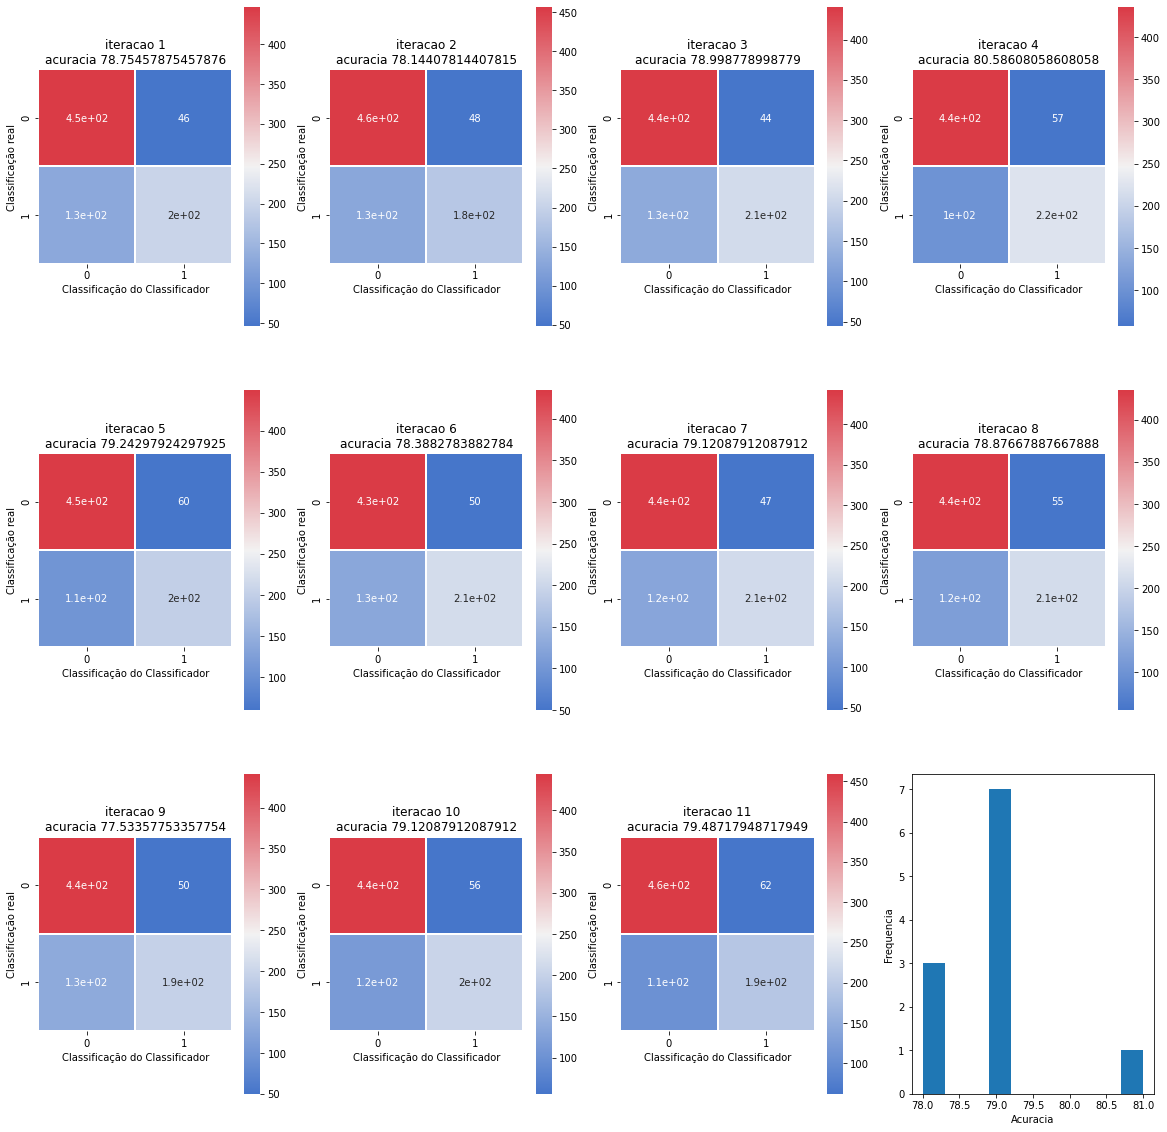

Sout


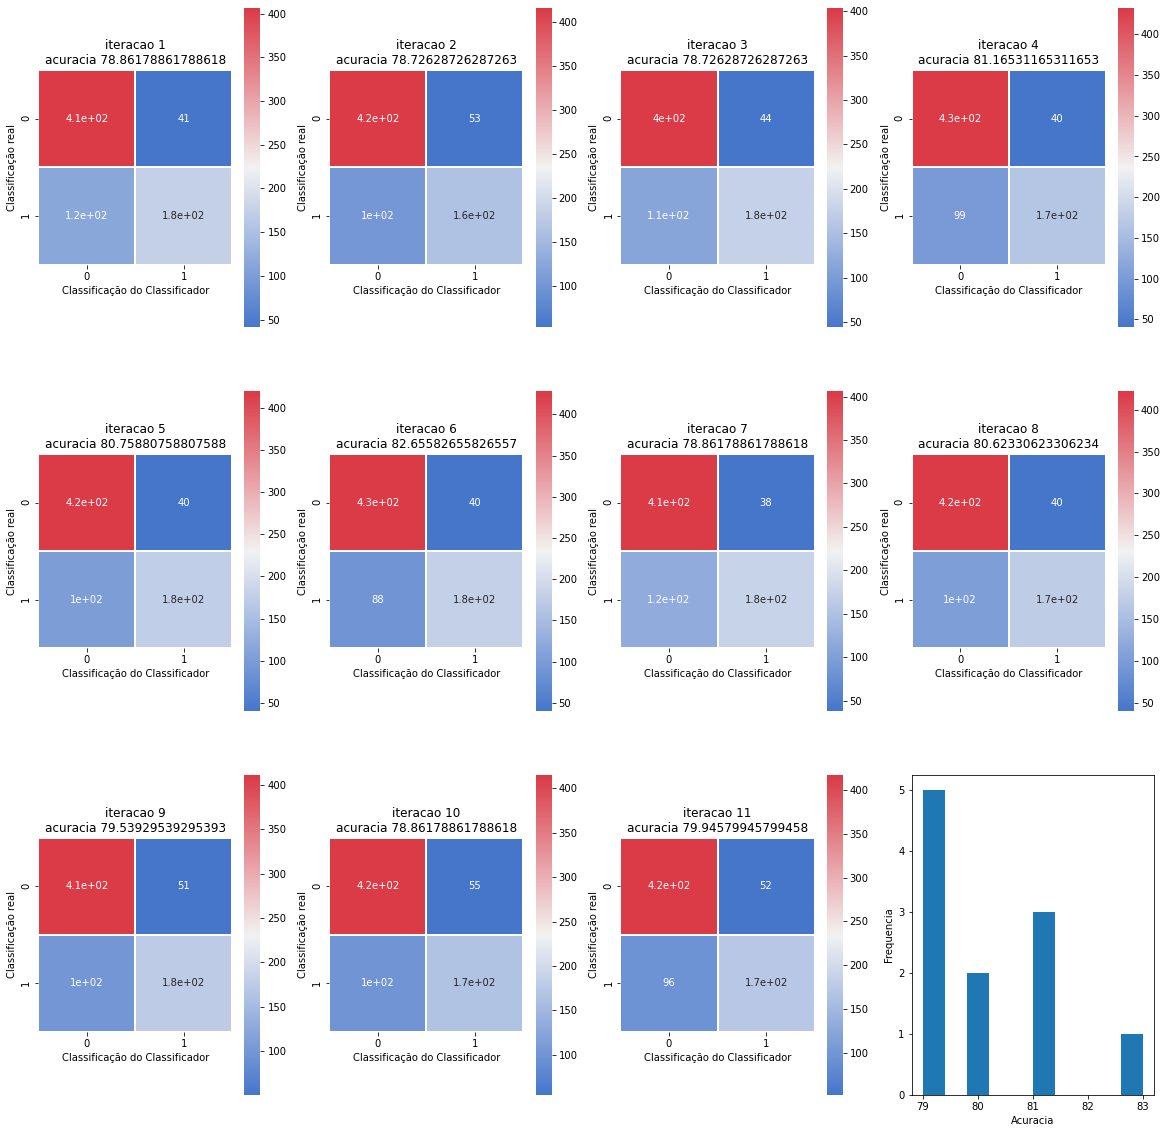

Cout                                                                \
             Vp   Vn  Fp   Fn acuracia_treino acuracia_teste precision_treino   
iteracao1   198  447  46  128           100.0      78.754579            100.0   
iteracao2   183  457  48  131           100.0      78.144078            100.0   
iteracao3   206  441  44  128           100.0      78.998779            100.0   
iteracao4   224  436  57  102           100.0      80.586081            100.0   
iteracao5   200  449  60  110           100.0      79.242979            100.0   
iteracao6   208  434  50  127           100.0      78.388278            100.0   
iteracao7   206  442  47  124           100.0      79.120879            100.0   
iteracao8   211  435  55  118           100.0      78.876679            100.0   
iteracao9   194  441  50  134           100.0      77.533578            100.0   
iteracao10  204  444  56  115           100.0      79.120879            100.0   
iteracao11  192  459  62  106           100.0      79.487179            100.0   

                           Sout                                               \
           precision_teste   Vp   Vn  Fp   Fn acuracia_treino acuracia_teste   
iteracao1        81.147541  175  407  41  115           100.0      78.861789   
iteracao2        79.220779  165  416  53  104           100.0      78.726287   
iteracao3        82.400000  177  404  44  113           100.0      78.726287   
iteracao4        79.715302  166  433  40   99           100.0      81.165312   
iteracao5        76.923077  176  420  40  102           100.0      80.758808   
iteracao6        80.620155  182  428  40   88           100.0      82.655827   
iteracao7        81.422925  176  406  38  118           100.0      78.861789   
iteracao8        79.323308  173  422  40  103           100.0      80.623306   
iteracao9        79.508197  176  411  51  100           100.0      79.539295   
iteracao10       78.461538  167  415  55  101           100.0      78.861789   
iteracao11       75.590551  173  417  52   96           100.0      79.945799   

                                                  Cout-Sout                 \
           precision_treino precision_teste acuracia_treino acuracia_teste   
iteracao1             100.0       81.018519             0.0      -0.107210   
iteracao2             100.0       75.688073             0.0      -0.582209   
iteracao3             100.0       80.090498             0.0       0.272492   
iteracao4             100.0       80.582524             0.0      -0.579231   
iteracao5             100.0       81.481481             0.0      -1.515828   
iteracao6             100.0       81.981982             0.0      -4.267548   
iteracao7             100.0       82.242991             0.0       0.259091   
iteracao8             100.0       81.220657             0.0      -1.746627   
iteracao9             100.0       77.533040             0.0      -2.005718   
iteracao10            100.0       75.225225             0.0       0.259091   
iteracao11            100.0       76.888889             0.0      -0.458620   

                                             
           precision_treino precision_teste  
iteracao1               0.0        0.129022  
iteracao2               0.0        3.532706  
iteracao3               0.0        2.309502  
iteracao4               0.0       -0.867222  
iteracao5               0.0       -4.558405  
iteracao6               0.0       -1.361827  
iteracao7               0.0       -0.820066  
iteracao8               0.0       -1.897349  
iteracao9               0.0        1.975157  
iteracao10              0.0        3.236313  
iteracao11              0.0       -1.298338

Cout                                                     \
               Vp          Vn         Fp          Fn acuracia_treino   
count   11.000000   11.000000  11.000000   11.000000            11.0   
mean   202.363636  444.090909  52.272727  120.272727           100.0   
std     10.865291    8.336121   6.018154   10.761886             0.0   
min    183.000000  434.000000  44.000000  102.000000           100.0   
25%    196.000000  438.500000  47.500000  112.500000           100.0   
50%    204.000000  442.000000  50.000000  124.000000           100.0   
75%    207.000000  448.000000  56.500000  128.000000           100.0   
max    224.000000  459.000000  62.000000  134.000000           100.0   

                                                             Sout              \
      acuracia_teste precision_treino precision_teste          Vp          Vn   
count      11.000000             11.0       11.000000   11.000000   11.000000   
mean       78.932179            100.0       79.484852  173.272727  416.272727   
std         0.782515              0.0        1.980722    5.255300    9.144298   
min        77.533578            100.0       75.590551  165.000000  404.000000   
25%        78.571429            100.0       78.841159  170.000000  409.000000   
50%        78.998779            100.0       79.508197  175.000000  416.000000   
75%        79.181929            100.0       80.883848  176.000000  421.000000   
max        80.586081            100.0       82.400000  182.000000  433.000000   

                                                                              \
              Fp          Fn acuracia_treino acuracia_teste precision_treino   
count  11.000000   11.000000            11.0      11.000000             11.0   
mean   44.909091  103.545455           100.0      79.884208            100.0   
std     6.441344    8.779107             0.0       1.287425              0.0   
min    38.000000   88.000000           100.0      78.726287            100.0   
25%    40.000000   99.500000           100.0      78.861789            100.0   
50%    41.000000  102.000000           100.0      79.539295            100.0   
75%    51.500000  108.500000           100.0      80.691057            100.0   
max    55.000000  118.000000           100.0      82.655827            100.0   

                            Cout-Sout                                  \
      precision_teste acuracia_treino acuracia_teste precision_treino   
count       11.000000            11.0      11.000000             11.0   
mean        79.450353             0.0      -0.952029              0.0   
std          2.605030             0.0       1.368144              0.0   
min         75.225225             0.0      -4.267548              0.0   
25%         77.210964             0.0      -1.631228              0.0   
50%         80.582524             0.0      -0.579231              0.0   
75%         81.351069             0.0       0.075940              0.0   
max         82.242991             0.0       0.272492              0.0   

                       
      precision_teste  
count       11.000000  
mean         0.034500  
std          2.480648  
min         -4.558405  
25%         -1.330082  
50%         -0.820066  
75%          2.142330  
max          3.532706

In [65]:
J = metricas(lista_tts, lista_RF)
display(J)
display(J.describe())

## XG_BOOST. Expectativas para os resultados gerados

O XGB tende a ser mais adequado que o RF, e é esperado que no projeto essa característa continue concreta. Dito isso, é previsto que os dados gerados pelo XGB sigam os mesmo padrão que os gerados pelo RF. No entanto, com valores de acurácia e precisão mais elevados. Também é almejado que a base de dados, com ou sem outliers, que obter a melhor performance no RF, também vá obter a melhor performace no XGB.



Cout


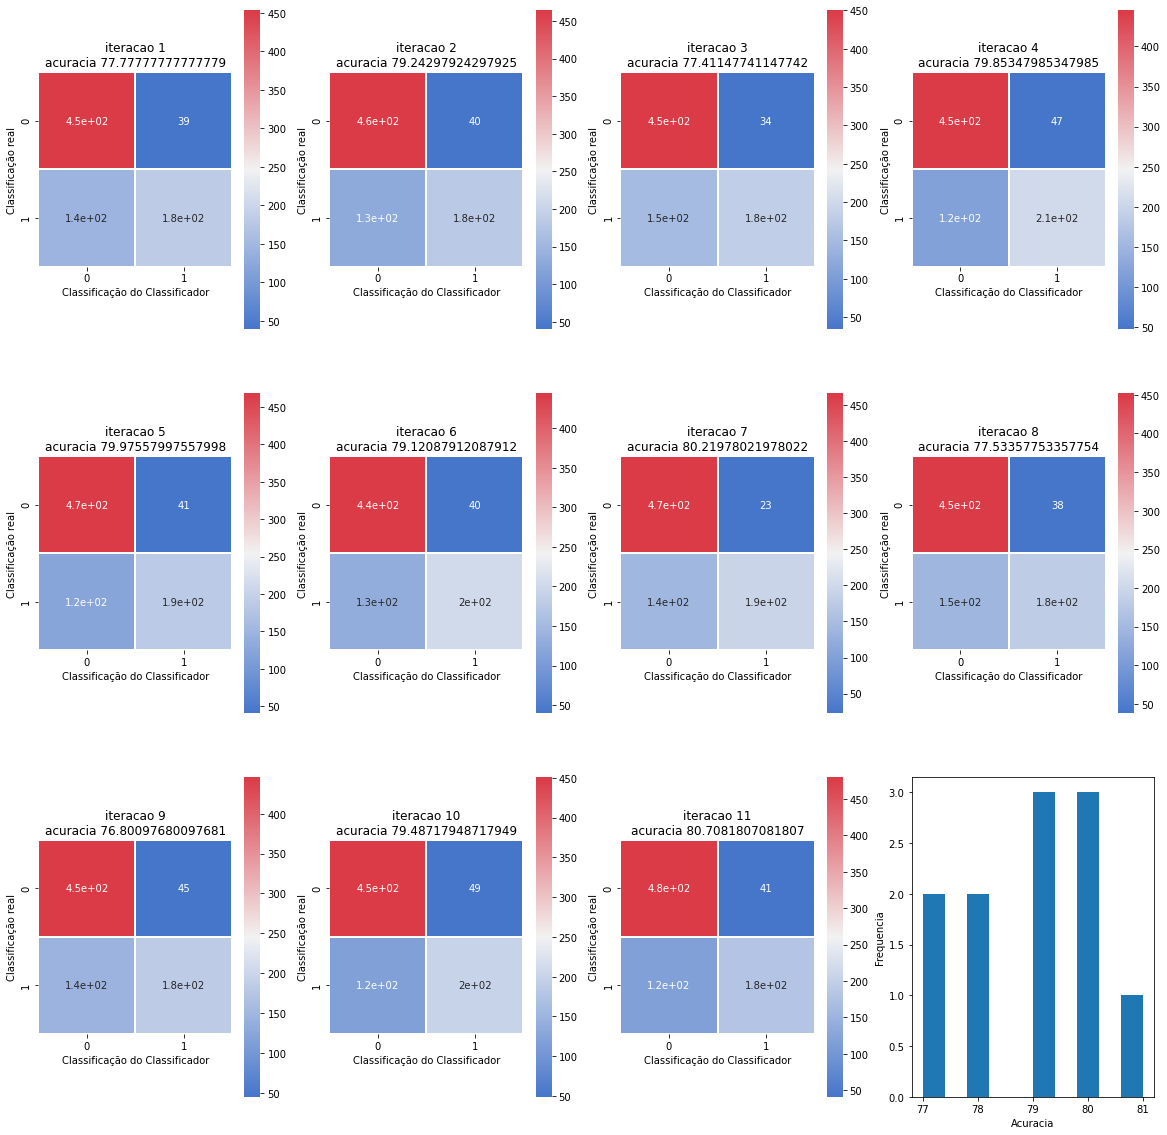

Sout


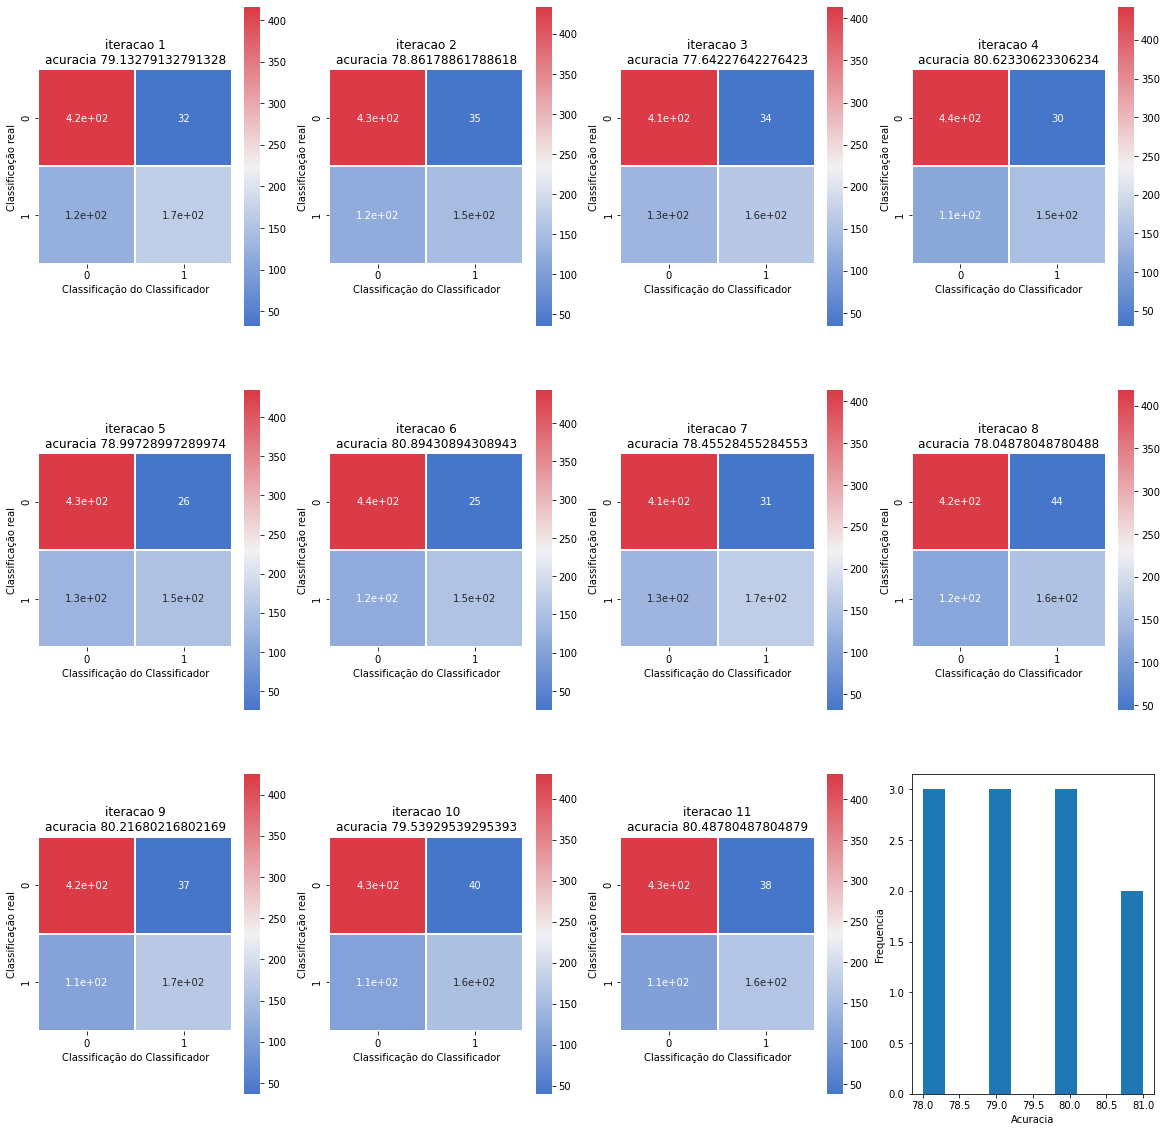

Cout                                                                \
             Vp   Vn  Fp   Fn acuracia_treino acuracia_teste precision_treino   
iteracao1   183  454  39  143       85.877086      77.777778        93.904209   
iteracao2   184  465  40  130       86.528287      79.242979        92.944369   
iteracao3   183  451  34  151       85.917786      77.411477        94.626866   
iteracao4   208  446  47  118       86.202686      79.853480        93.723252   
iteracao5   187  468  41  123       85.592186      79.975580        93.239437   
iteracao6   204  444  40  131       86.324786      79.120879        94.962963   
iteracao7   191  466  23  139       85.917786      80.219780        94.264706   
iteracao8   183  452  38  146       85.714286      77.533578        93.333333   
iteracao9   183  446  45  145       86.284086      76.800977        93.475177   
iteracao10  200  451  49  119       85.836386      79.487179        93.705293   
iteracao11  181  480  41  117       86.039886      80.708181        93.098782   

                           Sout                                               \
           precision_teste   Vp   Vn  Fp   Fn acuracia_treino acuracia_teste   
iteracao1        82.432432  168  416  32  122       86.850429      79.132791   
iteracao2        82.142857  148  434  35  121       86.082241      78.861789   
iteracao3        84.331797  159  414  34  131       86.534117      77.642276   
iteracao4        81.568627  152  443  30  113       86.127429      80.623306   
iteracao5        82.017544  149  434  26  129       85.449616      78.997290   
iteracao6        83.606557  154  443  25  116       86.217804      80.894309   
iteracao7        89.252336  166  413  31  128       86.488929      78.455285   
iteracao8        82.805430  158  418  44  118       86.172616      78.048780   
iteracao9        80.263158  167  425  37  109       85.268866      80.216802   
iteracao10       80.321285  157  430  40  111       85.901491      79.539295   
iteracao11       81.531532  163  431  38  106       86.262991      80.487805   

                                                  Cout-Sout                 \
           precision_treino precision_teste acuracia_treino acuracia_teste   
iteracao1         95.652174       84.000000       -0.973343      -1.355014   
iteracao2         95.081967       80.874317        0.446045       0.381191   
iteracao3         94.991653       82.383420       -0.616331      -0.230799   
iteracao4         95.417349       83.516484        0.075257      -0.769826   
iteracao5         95.042735       85.142857        0.142570       0.978290   
iteracao6         95.394737       86.033520        0.106982      -1.773430   
iteracao7         95.563140       84.263959       -0.571143       1.764496   
iteracao8         94.745484       78.217822       -0.458331      -0.515203   
iteracao9         92.822186       81.862745        1.015220      -3.415825   
iteracao10        93.070866       79.695431       -0.065105      -0.052116   
iteracao11        94.822006       81.094527       -0.223105       0.220376   

                                             
           precision_treino precision_teste  
iteracao1         -1.747965       -1.567568  
iteracao2         -2.137598        1.268540  
iteracao3         -0.364787        1.948378  
iteracao4         -1.694096       -1.947856  
iteracao5         -1.803298       -3.125313  
iteracao6         -0.431774       -2.426962  
iteracao7         -1.298434        4.988377  
iteracao8         -1.412151        4.587608  
iteracao9          0.652991       -1.599587  
iteracao10         0.634427        0.625854  
iteracao11        -1.723224        0.437004

Cout                                                     \
               Vp          Vn         Fp          Fn acuracia_treino   
count   11.000000   11.000000  11.000000   11.000000       11.000000   
mean   189.727273  456.636364  39.727273  132.909091       86.021386   
std      9.706605   11.447906   6.972674   12.501636        0.283947   
min    181.000000  444.000000  23.000000  117.000000       85.592186   
25%    183.000000  448.500000  38.500000  121.000000       85.856736   
50%    184.000000  452.000000  40.000000  131.000000       85.917786   
75%    195.500000  465.500000  43.000000  144.000000       86.243386   
max    208.000000  480.000000  49.000000  151.000000       86.528287   

                                                             Sout              \
      acuracia_teste precision_treino precision_teste          Vp          Vn   
count      11.000000        11.000000       11.000000   11.000000   11.000000   
mean       78.921079        93.752581       82.752141  158.272727  427.363636   
std         1.316501         0.641440        2.479687    7.100576   10.975179   
min        76.800977        92.944369       80.263158  148.000000  413.000000   
25%        77.655678        93.286385       81.550079  153.000000  417.000000   
50%        79.242979        93.705293       82.142857  158.000000  430.000000   
75%        79.914530        94.084457       83.205994  164.500000  434.000000   
max        80.708181        94.962963       89.252336  168.000000  443.000000   

                                                                              \
              Fp          Fn acuracia_treino acuracia_teste precision_treino   
count  11.000000   11.000000       11.000000      11.000000        11.000000   
mean   33.818182  118.545455       86.123321      79.354521        94.782209   
std     5.793413    8.454154        0.457915       1.091224         0.954997   
min    25.000000  106.000000       85.268866      77.642276        92.822186   
25%    30.500000  112.000000       85.991866      78.658537        94.783745   
50%    34.000000  118.000000       86.172616      79.132791        95.042735   
75%    37.500000  125.000000       86.375960      80.352304        95.406043   
max    44.000000  131.000000       86.850429      80.894309        95.652174   

                            Cout-Sout                                  \
      precision_teste acuracia_treino acuracia_teste precision_treino   
count       11.000000       11.000000      11.000000        11.000000   
mean        82.462280       -0.101935      -0.433442        -1.029628   
std          2.389354        0.554104       1.405731         0.994137   
min         78.217822       -0.973343      -3.415825        -2.137598   
25%         80.984422       -0.514737      -1.062420        -1.735595   
50%         82.383420       -0.065105      -0.230799        -1.412151   
75%         84.131980        0.124776       0.300783        -0.398280   
max         86.033520        1.015220       1.764496         0.652991   

                       
      precision_teste  
count       11.000000  
mean         0.289861  
std          2.747029  
min         -3.125313  
25%         -1.773722  
50%          0.437004  
75%          1.608459  
max          4.988377

In [66]:
J = metricas(lista_tts, lista_XGB)
display(J)
display(J.describe())

## Logistic Regression. Expectativas para os resultados gerados 

É esperado que os dados gerados pelo LR sejam consideravelmente menos precisos e menos acurados. A RL segue o mesmo princípio de conversão de variáveis contínuas para variáveis discretas que uma rede neural segue. Com isso em mente, espera-se que, pelo fato de a base de dados ser muito pequena, a RL nao conseguirá adaptar a base adequadamente e tenderá a classificar todos as águas como não potáveis exibindo, assim, caracteristicas de um modelo preguiçoso.



Cout


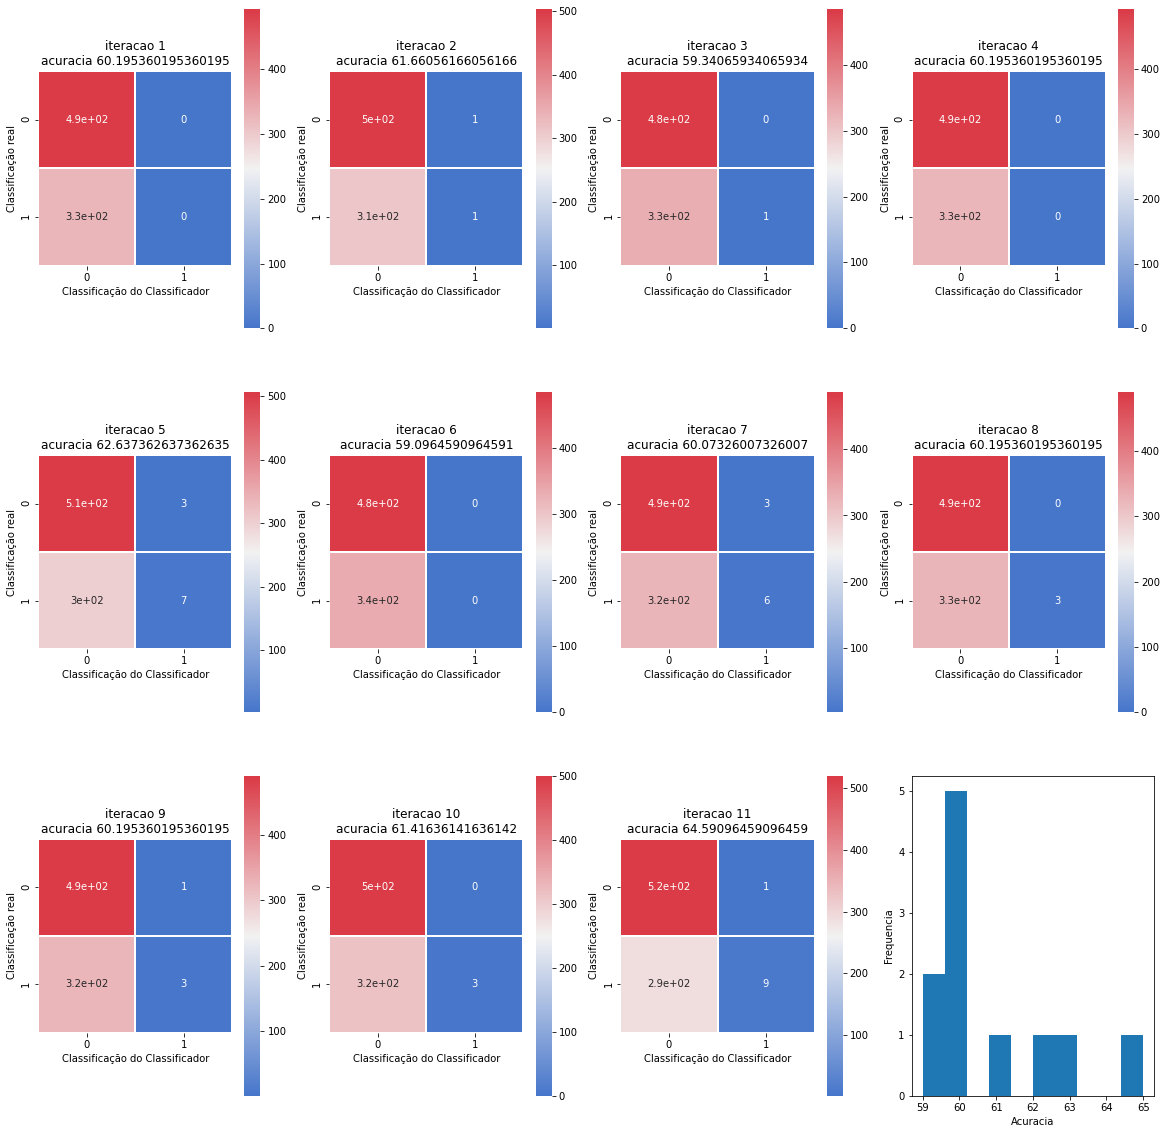

Sout


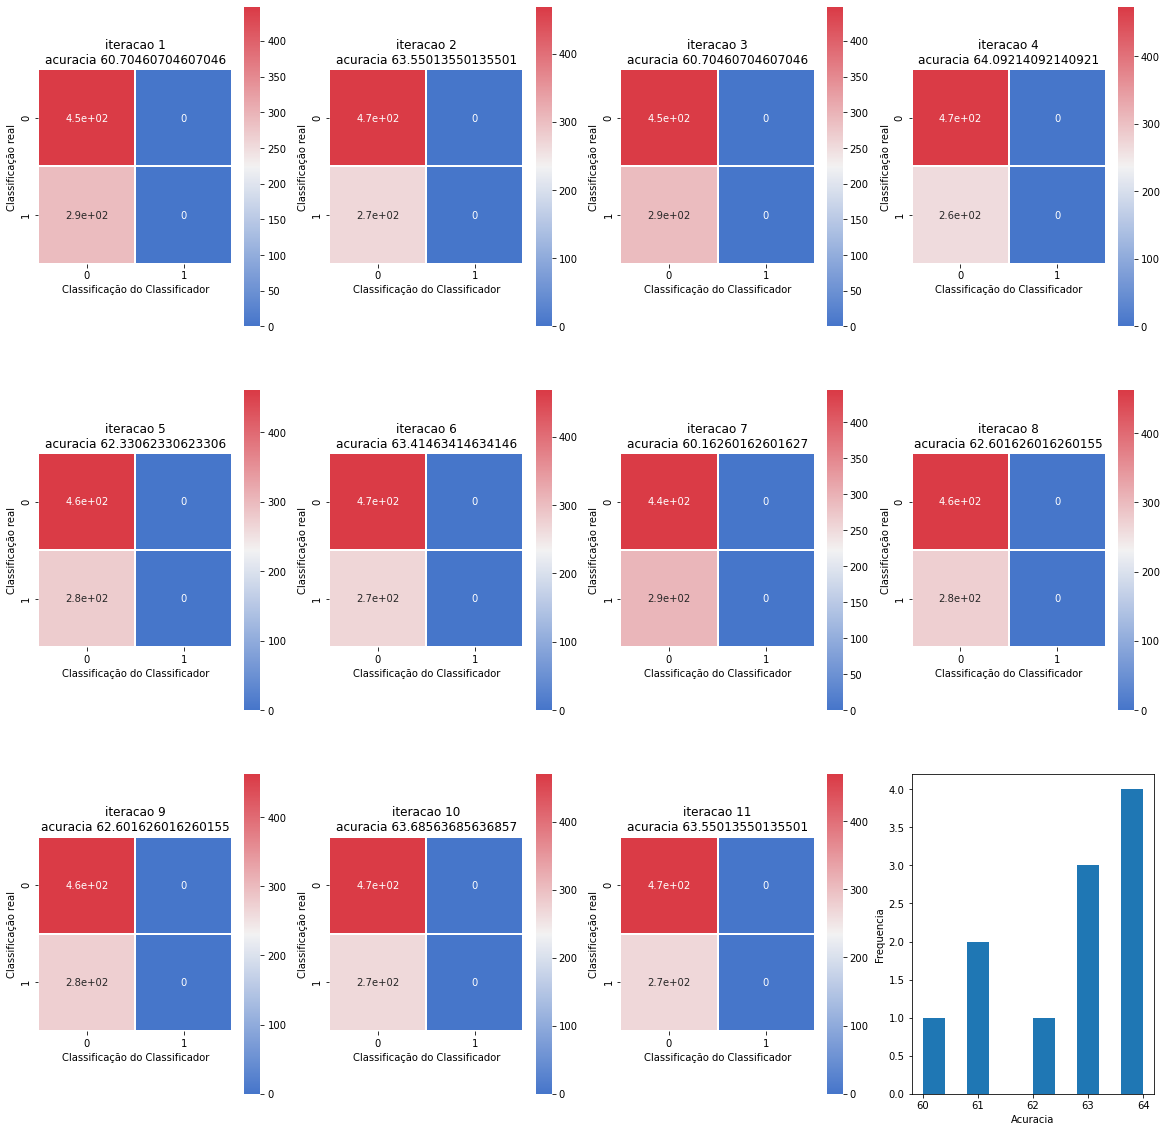

Cout                                                               \
             Vp   Vn Fp   Fn acuracia_treino acuracia_teste precision_treino   
iteracao1     0  493  0  326       61.294261      60.195360       100.000000   
iteracao2     1  504  1  313       60.805861      61.660562        60.000000   
iteracao3     1  485  0  333       61.619862      59.340659        66.666667   
iteracao4     0  493  0  326       61.253561      60.195360         0.000000   
iteracao5     7  506  3  303       61.375661      62.637363       100.000000   
iteracao6     0  484  0  335       61.701262      59.096459       100.000000   
iteracao7     6  486  3  324       62.800163      60.073260        85.416667   
iteracao8     3  490  0  326       61.579162      60.195360        77.777778   
iteracao9     3  490  1  325       62.026862      60.195360        94.736842   
iteracao10    3  500  0  316       61.294261      61.416361       100.000000   
iteracao11    9  520  1  289       60.643061      64.590965        84.210526   

                           Sout                                              \
           precision_teste   Vp   Vn Fp   Fn acuracia_treino acuracia_teste   
iteracao1         0.000000    0  448  0  290       62.178039      60.704607   
iteracao2        50.000000    0  469  0  269       61.229101      63.550136   
iteracao3       100.000000    0  448  0  290       62.178039      60.704607   
iteracao4         0.000000    0  473  0  265       61.048351      64.092141   
iteracao5        70.000000    0  460  0  278       61.635789      62.330623   
iteracao6         0.000000    0  468  0  270       61.274288      63.414634   
iteracao7        66.666667    0  444  0  294       62.358789      60.162602   
iteracao8       100.000000    0  462  0  276       61.545413      62.601626   
iteracao9        75.000000    0  462  0  276       61.816539      62.601626   
iteracao10      100.000000    0  470  0  268       61.183913      63.685637   
iteracao11       90.000000    0  469  0  269       61.229101      63.550136   

                                                  Cout-Sout                 \
           precision_treino precision_teste acuracia_treino acuracia_teste   
iteracao1               0.0             0.0       -0.883778      -0.509247   
iteracao2               0.0             0.0       -0.423240      -1.889574   
iteracao3               0.0             0.0       -0.558177      -1.363948   
iteracao4               0.0             0.0        0.205211      -3.896781   
iteracao5               0.0             0.0       -0.260127       0.306739   
iteracao6               0.0             0.0        0.426973      -4.318175   
iteracao7               0.0             0.0        0.441374      -0.089342   
iteracao8               0.0             0.0        0.033748      -2.406266   
iteracao9             100.0             0.0        0.210323      -2.406266   
iteracao10              0.0             0.0        0.110348      -2.269275   
iteracao11              0.0             0.0       -0.586040       1.040829   

                                             
           precision_treino precision_teste  
iteracao1        100.000000        0.000000  
iteracao2         60.000000       50.000000  
iteracao3         66.666667      100.000000  
iteracao4          0.000000        0.000000  
iteracao5        100.000000       70.000000  
iteracao6        100.000000        0.000000  
iteracao7         85.416667       66.666667  
iteracao8         77.777778      100.000000  
iteracao9         -5.263158       75.000000  
iteracao10       100.000000      100.000000  
iteracao11        84.210526       90.000000

Cout                                                     \
              Vp          Vn         Fp          Fn acuracia_treino   
count  11.000000   11.000000  11.000000   11.000000       11.000000   
mean    3.000000  495.545455   0.818182  319.636364       61.490361   
std     3.098387   10.994213   1.167748   13.625511        0.583536   
min     0.000000  484.000000   0.000000  289.000000       60.643061   
25%     0.500000  488.000000   0.000000  314.500000       61.273911   
50%     3.000000  493.000000   0.000000  325.000000       61.375661   
75%     4.500000  502.000000   1.000000  326.000000       61.660562   
max     9.000000  520.000000   3.000000  335.000000       62.800163   

                                                       Sout                    \
      acuracia_teste precision_treino precision_teste    Vp          Vn    Fp   
count      11.000000        11.000000       11.000000  11.0   11.000000  11.0   
mean       60.872461        78.982589       59.242424   0.0  461.181818   0.0   
std         1.607242        29.724692       41.186322   0.0   10.156950   0.0   
min        59.096459         0.000000        0.000000   0.0  444.000000   0.0   
25%        60.134310        72.222222       25.000000   0.0  454.000000   0.0   
50%        60.195360        85.416667       70.000000   0.0  462.000000   0.0   
75%        61.538462       100.000000       95.000000   0.0  469.000000   0.0   
max        64.590965       100.000000      100.000000   0.0  473.000000   0.0   

                                                                   \
               Fn acuracia_treino acuracia_teste precision_treino   
count   11.000000       11.000000      11.000000        11.000000   
mean   276.818182       61.607033      62.490761         9.090909   
std     10.156950        0.464036       1.376281        30.151134   
min    265.000000       61.048351      60.162602         0.000000   
25%    269.000000       61.229101      61.517615         0.000000   
50%    276.000000       61.545413      62.601626         0.000000   
75%    284.000000       61.997289      63.550136         0.000000   
max    294.000000       62.358789      64.092141       100.000000   

                            Cout-Sout                                  \
      precision_teste acuracia_treino acuracia_teste precision_treino   
count            11.0       11.000000      11.000000        11.000000   
mean              0.0       -0.116671      -1.618300        69.891680   
std               0.0        0.448320       1.692013        38.439084   
min               0.0       -0.883778      -4.318175        -5.263158   
25%               0.0       -0.490709      -2.406266        63.333333   
50%               0.0        0.033748      -1.889574        84.210526   
75%               0.0        0.207767      -0.299294       100.000000   
max               0.0        0.441374       1.040829       100.000000   

                       
      precision_teste  
count       11.000000  
mean        59.242424  
std         41.186322  
min          0.000000  
25%         25.000000  
50%         70.000000  
75%         95.000000  
max        100.000000

In [67]:
J = metricas(lista_tts, lista_LR)
display(J)
display(J.describe())

## Neural Network (Simulated only once).
Uma NN é uma sub categoria de machine learning e a base para o deep learning (subcategoria de NN). Quanto mais específica a técnica se torna, mais dados ela requer e ,como a NN é uma das técnicas mais avançadas, é esperado que um desempenho similar ao do LR. Isso acontece porque as implicações geradas são as mesmas - a falta de dados. Outro contribuinte para essa hipótese é o fato de que a NN tambem utiliza o função sigmoid para converter variáveis contínuas em discretas.



### Com Outliers

In [68]:
my_neural_network(ttSout_split[0], ttSout_split[1], ttSout_split[2], ttSout_split[3], loss='binary_crossentropy', metrics=['accuracy'], epochs=50)

Epoch 1/50
2213/2213 [==============================] - 2s 677us/step - loss: 0.6769 - accuracy: 0.6109
Epoch 2/50
2213/2213 [==============================] - 2s 740us/step - loss: 0.6600 - accuracy: 0.6227
Epoch 3/50
2213/2213 [==============================] - 1s 676us/step - loss: 0.6505 - accuracy: 0.6299
Epoch 4/50
2213/2213 [==============================] - 1s 677us/step - loss: 0.6382 - accuracy: 0.6448
Epoch 5/50
2213/2213 [==============================] - 2s 720us/step - loss: 0.6279 - accuracy: 0.6521
Epoch 6/50
2213/2213 [==============================] - 2s 688us/step - loss: 0.6238 - accuracy: 0.6638
Epoch 7/50
2213/2213 [==============================] - 2s 781us/step - loss: 0.6246 - accuracy: 0.6737
Epoch 8/50
2213/2213 [==============================] - 2s 754us/step - loss: 0.6201 - accuracy: 0.6679
Epoch 9/50
2213/2213 [==============================] - 1s 675us/step - loss: 0.6186 - accuracy: 0.6697
Epoch 10/50
2213/2213 [==============================] - 1s 671u

{'loss': 0.9451658725738525, 'accuracy': 0.6720867156982422}

### Sem Outliers

In [69]:
my_neural_network(ttSout_split[0], ttSout_split[1], ttSout_split[2], ttSout_split[3], loss='binary_crossentropy', metrics=['accuracy'], epochs=50)

Epoch 1/50
2213/2213 [==============================] - 2s 625us/step - loss: 0.6665 - accuracy: 0.6109
Epoch 2/50
2213/2213 [==============================] - 2s 698us/step - loss: 0.6411 - accuracy: 0.6349
Epoch 3/50
2213/2213 [==============================] - 1s 663us/step - loss: 0.6310 - accuracy: 0.6453
Epoch 4/50
2213/2213 [==============================] - 1s 646us/step - loss: 0.6264 - accuracy: 0.6629
Epoch 5/50
2213/2213 [==============================] - 1s 670us/step - loss: 0.6273 - accuracy: 0.6692
Epoch 6/50
2213/2213 [==============================] - 1s 661us/step - loss: 0.6264 - accuracy: 0.6643
Epoch 7/50
2213/2213 [==============================] - 1s 657us/step - loss: 0.6296 - accuracy: 0.6769
Epoch 8/50
2213/2213 [==============================] - 1s 637us/step - loss: 0.6270 - accuracy: 0.6746
Epoch 9/50
2213/2213 [==============================] - 2s 735us/step - loss: 0.6296 - accuracy: 0.6814
Epoch 10/50
2213/2213 [==============================] - 1s 675u

{'loss': 0.8557318449020386, 'accuracy': 0.6666666865348816}

# Considerações finais sobre os modelos e os dados gerados por eles

A hipótese prevista para a Regressão logística e para a Rede neural se provou correta. No entanto, essa estimativa para o Random Forest e para o XGBoost se mostrou apenas parcialmente correta. Enquanto as médias do RF e do XGB para precisão e acurácia das bases de dados com e sem outliers estavam dentro da mergem prevista de 3 pontos, o RF teve uma acurácia maior do que o XGB, enquanto o contrário acontece para a precisão. Sendo assim, é possível dizer que, nesse caso, analisando os dois modelos como um todo, não é possivel dizer que um é mais eficaz que o outro sempre - mas pode-se afirmar que o XGB se provou melhor para o projeto, pois a precisao é mais necessária do que a acurácia, uma vez que estamos tratando de algo que é feito para consumo humano.



# Evitando falsos positivos: a importância da definição correta

Como acontece acima, a precisão e a acurácia são medidas importantes e relevantes na decisão de qual modelo é mais adequado. Nesse projeto, é necessário evitar falsos positivos, visto que, ao considerar uma água potável e segura para consumo quando isso não é verdade, ou seja, quando acontece um falso positivo, torna-se perigoso para a pessoa que for ingerir esta água. Assim, a chance de uma pessoa ingerir uma água teoricamente segura, quando perigosa, diminui. Como consequência, mais águas seguras serão descartadas, em virtude da segurança das pessoas que irão consumir a água.

# Random Forest

In [70]:
def RF_Clf_Fn(Train_X, Test_X, Train_Y, Test_Y):
    RF_clf = RandomForestC()
    RF_clf.fit(Train_X, Train_Y)
    RF_train_predicted_proba = RF_clf.predict_proba(Train_X)
    RF_train_pred = (RF_train_predicted_proba [:,1] >= 0.8).astype('int')
    RF_test_predicted_proba = RF_clf.predict_proba(Test_X)
    RF_test_pred = (RF_test_predicted_proba [:,1] >= 0.8).astype('int')
    RF_train_score = accuracy_score(Train_Y, RF_train_pred)*100
    RF_train_Precisionscore = precision_score(Train_Y, RF_train_pred)*100
    RF_test_score = accuracy_score(Test_Y, RF_test_pred)*100
    RF_test_Precisionscore = precision_score(Test_Y, RF_test_pred)*100
    return [[RF_train_score, RF_test_score, RF_test_pred], [RF_train_Precisionscore, RF_test_Precisionscore]]

# XG_BOOST

In [71]:
def XGB_Clf_Fn(Train_X, Test_X, Train_Y, Test_Y):
    XGB_clf = RandomForestC()
    XGB_clf.fit(Train_X, Train_Y)
    XGB_train_predicted_proba = XGB_clf.predict_proba(Train_X)
    XGB_train_pred = (XGB_train_predicted_proba [:,1] >= 0.8).astype('int')
    XGB_test_predicted_proba = XGB_clf.predict_proba(Test_X)
    XGB_test_pred = (XGB_test_predicted_proba [:,1] >= 0.8).astype('int')
    XGB_train_score = accuracy_score(Train_Y, XGB_train_pred)*100
    XGB_train_Precisionscore = precision_score(Train_Y, XGB_train_pred)*100
    XGB_test_score = accuracy_score(Test_Y, XGB_test_pred)*100
    XGB_test_Precisionscore = precision_score(Test_Y, XGB_test_pred)*100
    return [[XGB_train_score, XGB_test_score, XGB_test_pred], [XGB_train_Precisionscore, XGB_test_Precisionscore]]

# Rodando os classificadores

In [72]:
listaCout_tts_Fn = []; listaSout_tts_Fn = []; lista_tts_Fn = [[], []]; lista_RF_Fn = [[], []]; lista_XGB_Fn = [[], []]
for i in range(11):
    ttCout_split = tts(df_agua1.drop(['Potability'], axis=1), df_agua1.Potability, test_size=0.25)
    ttSout_split = tts(df_agua1_Sout.drop(['Potability'], axis=1), df_agua1_Sout.Potability, test_size=0.25)
    lista_tts_Fn[0].append(ttCout_split)
    lista_tts_Fn[1].append(ttSout_split)
    lista_RF_Fn[0].append(RF_Clf_Fn(ttCout_split[0], ttCout_split[1], ttCout_split[2], ttCout_split[3]))
    lista_RF_Fn[1].append(RF_Clf_Fn(ttSout_split[0], ttSout_split[1], ttSout_split[2], ttSout_split[3]))
    lista_XGB_Fn[0].append(XGB_Clf_Fn(ttCout_split[0], ttCout_split[1], ttCout_split[2], ttCout_split[3]))
    lista_XGB_Fn[1].append(XGB_Clf_Fn(ttSout_split[0], ttSout_split[1], ttSout_split[2], ttSout_split[3]))

# Random Forest

Como o modelo foi é tendencioso para prever a variável target como não potável, é esperado que na segunda simulação a acurácia diminua e a precisão aumente - de modo que o segundo seja maior que o primeiro. Apesar da acurácia estar em menor valor, ainda será maior do que os dados obtidos a partir do LR e NN.

Cout


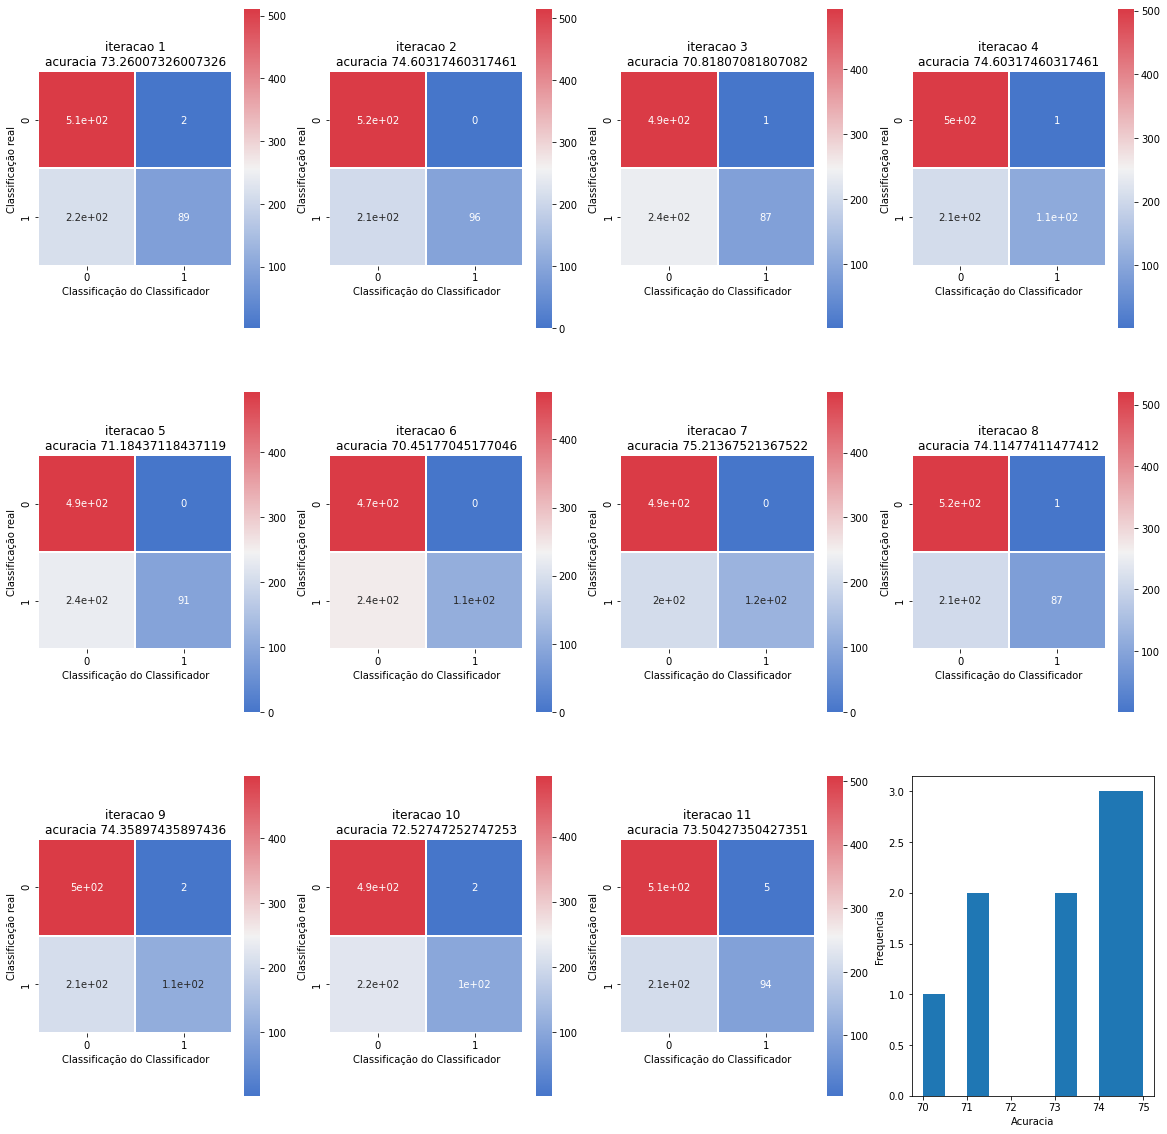

Sout


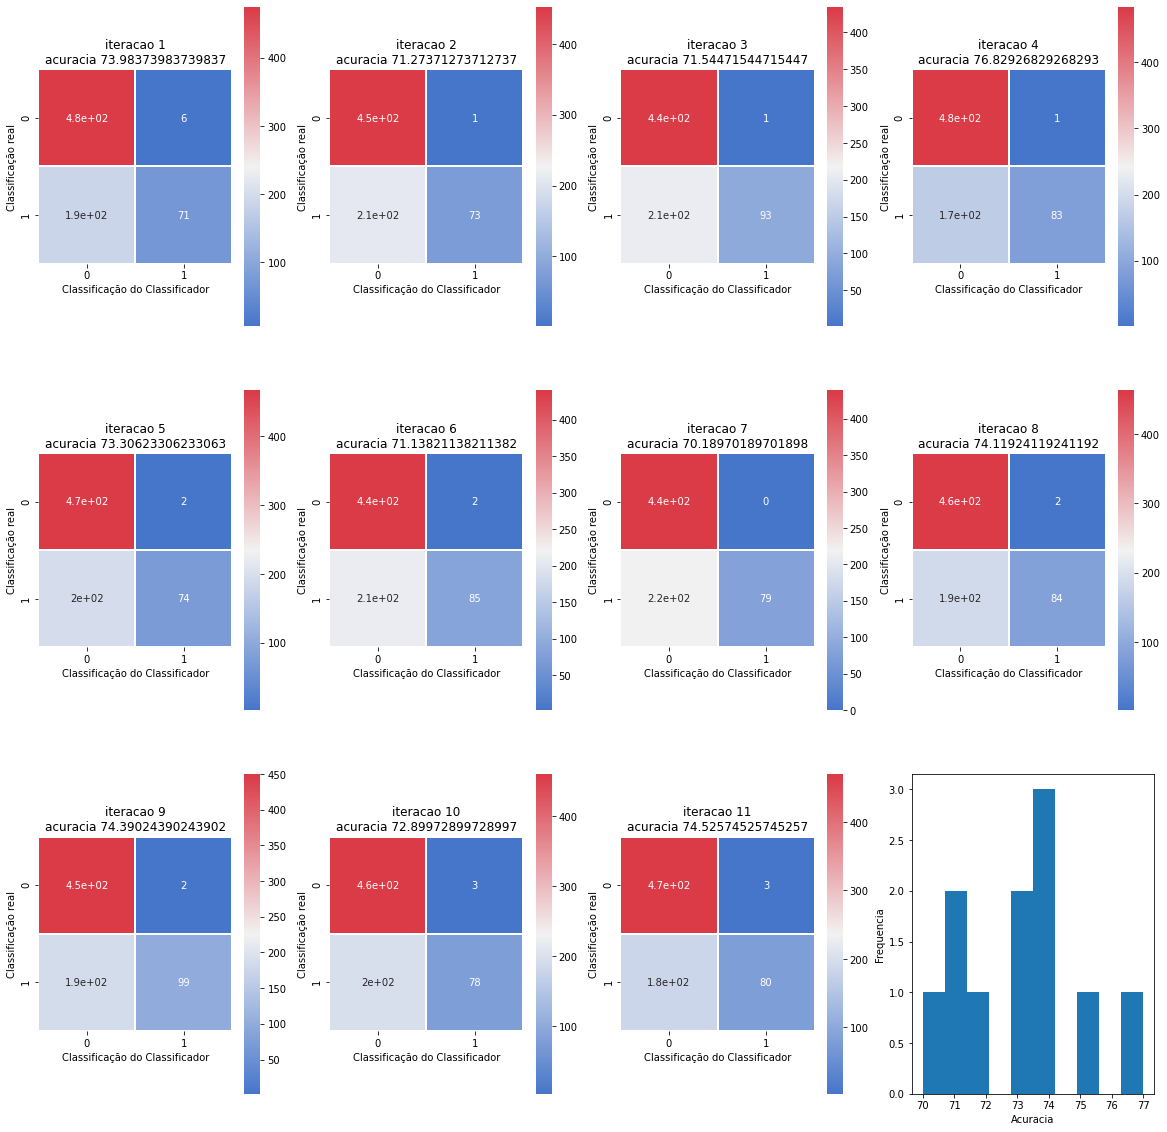

Cout                                                               \
             Vp   Vn Fp   Fn acuracia_treino acuracia_teste precision_treino   
iteracao1    89  511  2  217       89.255189      73.260073            100.0   
iteracao2    96  515  0  208       88.400488      74.603175            100.0   
iteracao3    87  493  1  238       88.481888      70.818071            100.0   
iteracao4   108  503  1  207       89.377289      74.603175            100.0   
iteracao5    91  492  0  236       89.051689      71.184371            100.0   
iteracao6   108  469  0  242       87.789988      70.451770            100.0   
iteracao7   123  493  0  203       88.766789      75.213675            100.0   
iteracao8    87  520  1  211       88.766789      74.114774            100.0   
iteracao9   113  496  2  208       88.359788      74.358974            100.0   
iteracao10  101  493  2  223       87.789988      72.527473            100.0   
iteracao11   94  508  5  212       88.522589      73.504274            100.0   

                           Sout                                              \
           precision_teste   Vp   Vn Fp   Fn acuracia_treino acuracia_teste   
iteracao1        97.802198   71  475  6  186       88.974243      73.983740   
iteracao2       100.000000   73  453  1  211       87.980117      71.273713   
iteracao3        98.863636   93  435  1  209       87.889742      71.544715   
iteracao4        99.082569   83  484  1  170       88.567555      76.829268   
iteracao5       100.000000   74  467  2  195       88.793493      73.306233   
iteracao6       100.000000   85  440  2  211       88.477180      71.138211   
iteracao7       100.000000   79  439  0  220       88.567555      70.189702   
iteracao8        98.863636   84  463  2  189       88.206055      74.119241   
iteracao9        98.260870   99  450  2  187       88.386805      74.390244   
iteracao10       98.058252   78  460  3  197       87.754180      72.899729   
iteracao11       94.949495   80  470  3  185       88.612743      74.525745   

                                                  Cout-Sout                 \
           precision_treino precision_teste acuracia_treino acuracia_teste   
iteracao1             100.0       92.207792        0.280946      -0.723667   
iteracao2             100.0       98.648649        0.420371       3.329462   
iteracao3             100.0       98.936170        0.592146      -0.726645   
iteracao4             100.0       98.809524        0.809734      -2.226094   
iteracao5             100.0       97.368421        0.258196      -2.121862   
iteracao6             100.0       97.701149       -0.687193      -0.686441   
iteracao7             100.0      100.000000        0.199233       5.023973   
iteracao8             100.0       97.674419        0.560734      -0.004467   
iteracao9             100.0       98.019802       -0.027017      -0.031270   
iteracao10            100.0       96.296296        0.035808      -0.372256   
iteracao11            100.0       96.385542       -0.090154      -1.021472   

                                             
           precision_treino precision_teste  
iteracao1               0.0        5.594406  
iteracao2               0.0        1.351351  
iteracao3               0.0       -0.072534  
iteracao4               0.0        0.273045  
iteracao5               0.0        2.631579  
iteracao6               0.0        2.298851  
iteracao7               0.0        0.000000  
iteracao8               0.0        1.189218  
iteracao9               0.0        0.241068  
iteracao10              0.0        1.761956  
iteracao11              0.0       -1.436047

Cout                                                     \
               Vp          Vn         Fp          Fn acuracia_treino   
count   11.000000   11.000000  11.000000   11.000000       11.000000   
mean    99.727273  499.363636   1.272727  218.636364       88.596589   
std     11.908744   14.151132   1.489356   13.973351        0.521792   
min     87.000000  469.000000   0.000000  203.000000       87.789988   
25%     90.000000  493.000000   0.000000  208.000000       88.380138   
50%     96.000000  496.000000   1.000000  212.000000       88.522589   
75%    108.000000  509.500000   2.000000  229.500000       88.909239   
max    123.000000  520.000000   5.000000  242.000000       89.377289   

                                                            Sout              \
      acuracia_teste precision_treino precision_teste         Vp          Vn   
count      11.000000             11.0       11.000000  11.000000   11.000000   
mean       73.149073            100.0       98.716423  81.727273  457.818182   
std         1.672776              0.0        1.497797   8.474561   15.879661   
min        70.451770            100.0       94.949495  71.000000  435.000000   
25%        71.855922            100.0       98.159561  76.000000  445.000000   
50%        73.504274            100.0       98.863636  80.000000  460.000000   
75%        74.481074            100.0      100.000000  84.500000  468.500000   
max        75.213675            100.0      100.000000  99.000000  484.000000   

                                                                              \
              Fp          Fn acuracia_treino acuracia_teste precision_treino   
count  11.000000   11.000000       11.000000      11.000000             11.0   
mean    2.090909  196.363636       88.382697      73.109140            100.0   
std     1.578261   14.908204        0.384734       1.938535              0.0   
min     0.000000  170.000000       87.754180      70.189702            100.0   
25%     1.000000  186.500000       88.093086      71.409214            100.0   
50%     2.000000  195.000000       88.477180      73.306233            100.0   
75%     2.500000  210.000000       88.590149      74.254743            100.0   
max     6.000000  220.000000       88.974243      76.829268            100.0   

                            Cout-Sout                                  \
      precision_teste acuracia_treino acuracia_teste precision_treino   
count       11.000000       11.000000      11.000000             11.0   
mean        97.458888        0.213891       0.039933              0.0   
std          2.058762        0.407659       2.201630              0.0   
min         92.207792       -0.687193      -2.226094              0.0   
25%         96.876982        0.004396      -0.874058              0.0   
50%         97.701149        0.258196      -0.686441              0.0   
75%         98.729086        0.490552      -0.017868              0.0   
max        100.000000        0.809734       5.023973              0.0   

                       
      precision_teste  
count       11.000000  
mean         1.257536  
std          1.861639  
min         -1.436047  
25%          0.120534  
50%          1.189218  
75%          2.030403  
max          5.594406

In [73]:
J = metricas(lista_tts_Fn, lista_RF_Fn)
display(J)
display(J.describe())

# XG_BOOST
Para o XGB, é esperado novamente o mesmo comportamento que foi apresentado no RF. Porém, considerando a primeira simulação, antecipa-se que a precisão do XGB seja maior do que a do RF, e a acurácia menor. Contudo, assim como acontece com o RF, estima-se que a acurácia do XGB continue maior do que a do LR e NN.



Cout


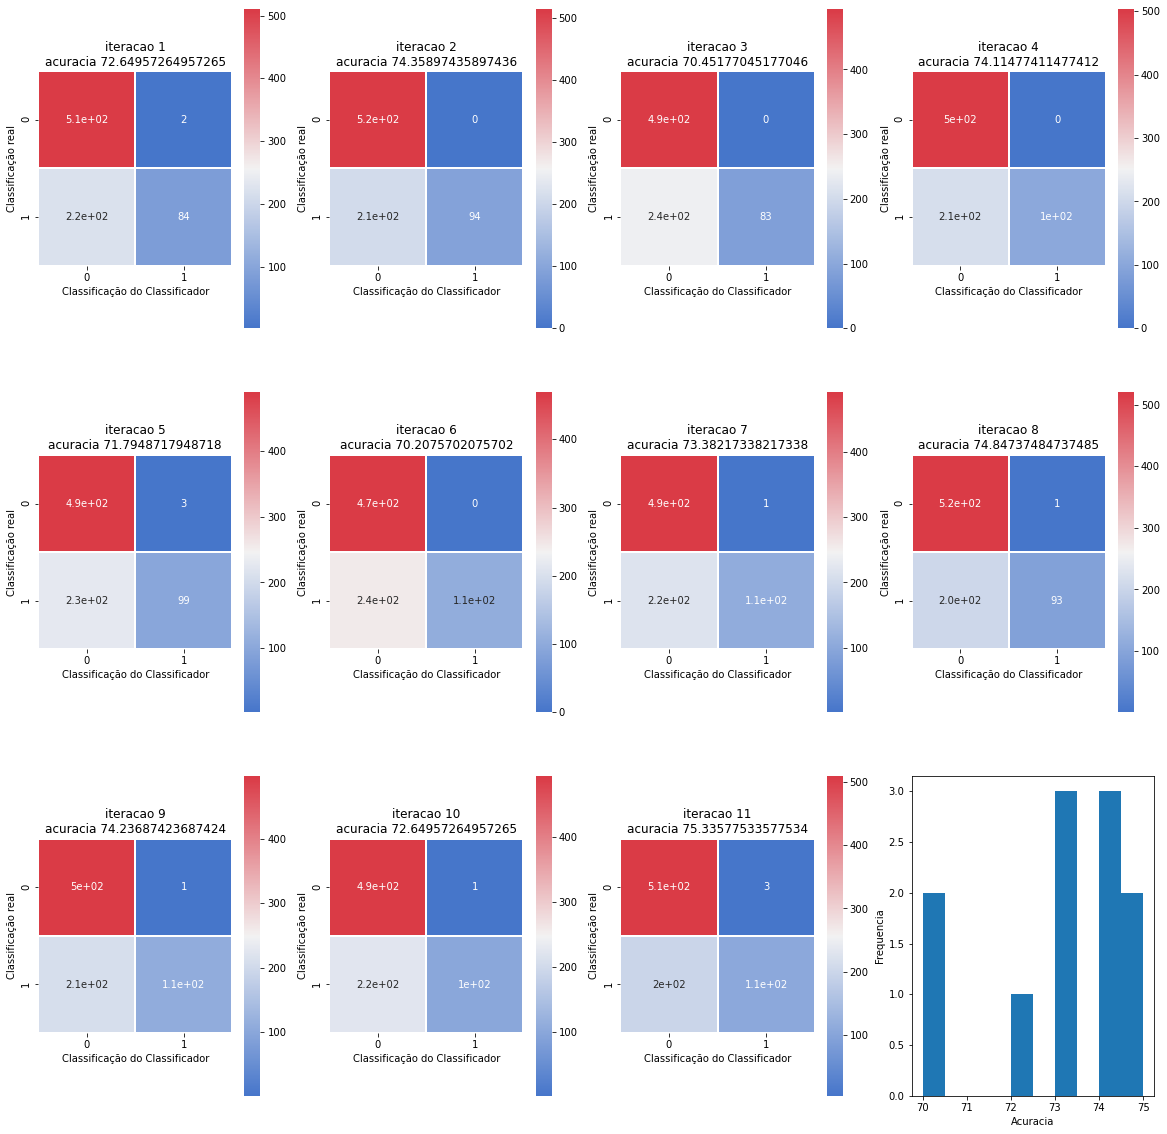

Sout


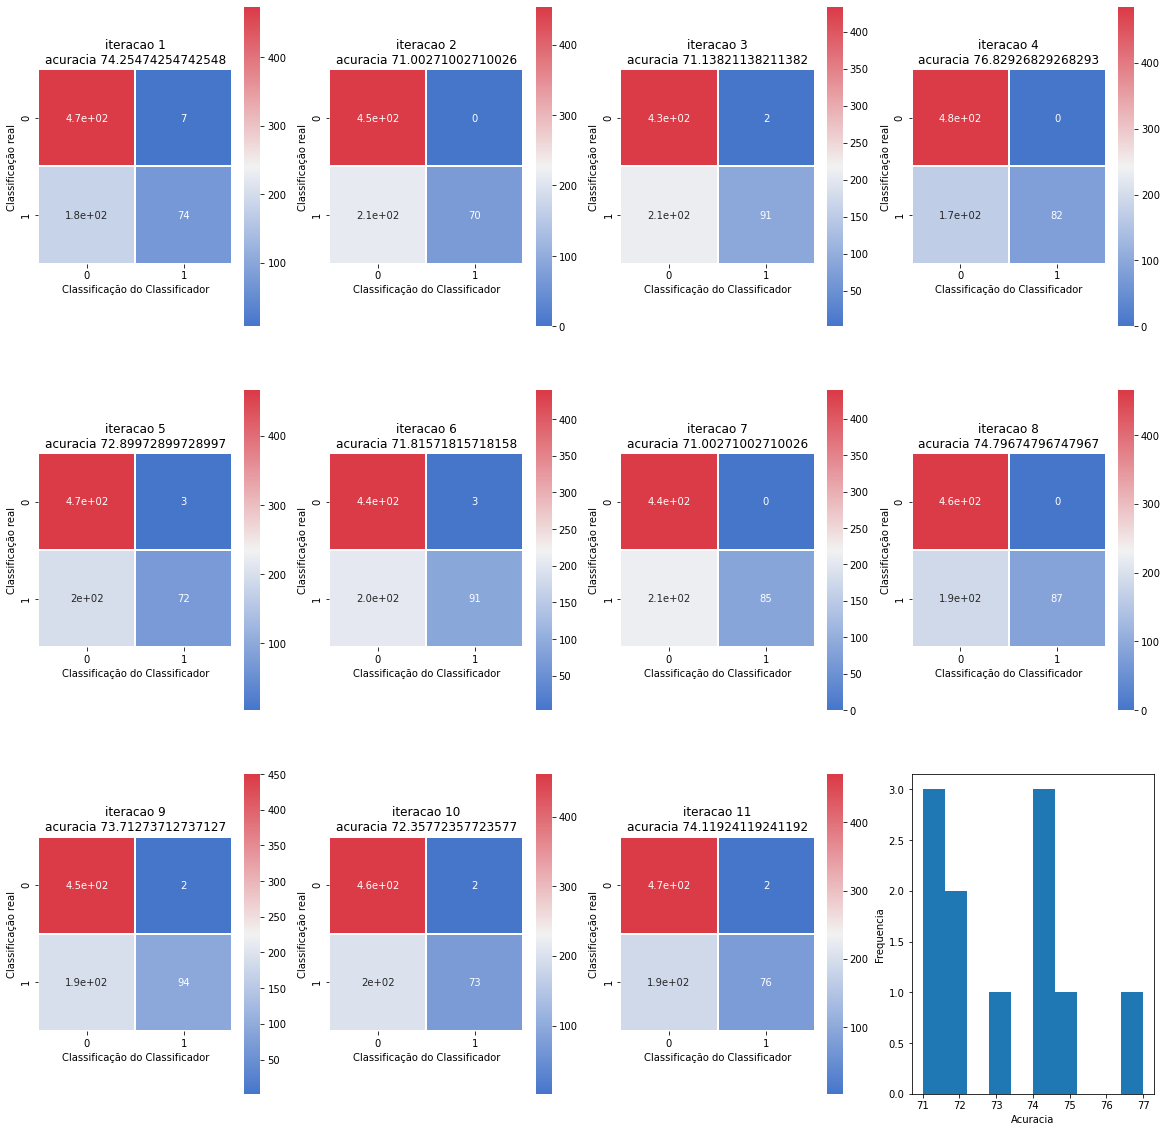

Cout                                                               \
             Vp   Vn Fp   Fn acuracia_treino acuracia_teste precision_treino   
iteracao1    84  511  2  222       89.540090      72.649573            100.0   
iteracao2    94  515  0  210       88.970289      74.358974            100.0   
iteracao3    83  494  0  242       88.848189      70.451770            100.0   
iteracao4   103  504  0  212       88.766789      74.114774            100.0   
iteracao5    99  489  3  228       88.807489      71.794872            100.0   
iteracao6   106  469  0  244       88.441188      70.207570            100.0   
iteracao7   109  492  1  217       88.888889      73.382173            100.0   
iteracao8    93  520  1  205       88.196988      74.847375            100.0   
iteracao9   111  497  1  210       88.156288      74.236874            100.0   
iteracao10  101  494  1  223       88.726089      72.649573            100.0   
iteracao11  107  510  3  199       89.092389      75.335775            100.0   

                           Sout                                              \
           precision_teste   Vp   Vn Fp   Fn acuracia_treino acuracia_teste   
iteracao1        97.674419   74  474  7  183       88.748305      74.254743   
iteracao2       100.000000   70  454  0  214       88.567555      71.002710   
iteracao3       100.000000   91  434  2  211       88.296430      71.138211   
iteracao4       100.000000   82  485  0  171       87.392680      76.829268   
iteracao5        97.058824   72  466  3  197       88.567555      72.899729   
iteracao6       100.000000   91  439  3  205       88.567555      71.815718   
iteracao7        99.090909   85  439  0  214       88.206055      71.002710   
iteracao8        98.936170   87  465  0  186       88.160868      74.796748   
iteracao9        99.107143   94  450  2  192       88.522368      73.712737   
iteracao10       99.019608   73  461  2  202       87.889742      72.357724   
iteracao11       97.272727   76  471  2  189       88.657930      74.119241   

                                                  Cout-Sout                 \
           precision_treino precision_teste acuracia_treino acuracia_teste   
iteracao1             100.0       91.358025        0.791784      -1.605170   
iteracao2             100.0      100.000000        0.402734       3.356264   
iteracao3             100.0       97.849462        0.551759      -0.686441   
iteracao4             100.0      100.000000        1.374109      -2.714494   
iteracao5             100.0       96.000000        0.239933      -1.104857   
iteracao6             100.0       96.808511       -0.126367      -1.608148   
iteracao7             100.0      100.000000        0.682834       2.379463   
iteracao8             100.0      100.000000        0.036121       0.050627   
iteracao9             100.0       97.916667       -0.366080       0.524137   
iteracao10            100.0       97.333333        0.836346       0.291849   
iteracao11            100.0       97.435897        0.434459       1.216534   

                                             
           precision_treino precision_teste  
iteracao1               0.0        6.316394  
iteracao2               0.0        0.000000  
iteracao3               0.0        2.150538  
iteracao4               0.0        0.000000  
iteracao5               0.0        1.058824  
iteracao6               0.0        3.191489  
iteracao7               0.0       -0.909091  
iteracao8               0.0       -1.063830  
iteracao9               0.0        1.190476  
iteracao10              0.0        1.686275  
iteracao11              0.0       -0.163170

Cout                                                     \
               Vp          Vn         Fp          Fn acuracia_treino   
count   11.000000   11.000000  11.000000   11.000000       11.000000   
mean    99.090909  499.545455   1.090909  219.272727       88.766789   
std      9.585975   14.445509   1.136182   14.388126        0.396695   
min     83.000000  469.000000   0.000000  199.000000       88.156288   
25%     93.500000  493.000000   0.000000  210.000000       88.583639   
50%    101.000000  497.000000   1.000000  217.000000       88.807489   
75%    106.500000  510.500000   1.500000  225.500000       88.929589   
max    111.000000  520.000000   3.000000  244.000000       89.540090   

                                                            Sout              \
      acuracia_teste precision_treino precision_teste         Vp          Vn   
count      11.000000             11.0       11.000000  11.000000   11.000000   
mean       73.093573            100.0       98.923618  81.363636  458.000000   
std         1.718338              0.0        1.116639   8.720926   16.291102   
min        70.207570            100.0       97.058824  70.000000  434.000000   
25%        72.222222            100.0       98.305294  73.500000  444.500000   
50%        73.382173            100.0       99.090909  82.000000  461.000000   
75%        74.297924            100.0      100.000000  89.000000  468.500000   
max        75.335775            100.0      100.000000  94.000000  485.000000   

                                                                              \
              Fp          Fn acuracia_treino acuracia_teste precision_treino   
count  11.000000   11.000000       11.000000      11.000000             11.0   
mean    1.909091  196.727273       88.325186      73.084504            100.0   
std     2.071451   13.943392        0.400756       1.855204              0.0   
min     0.000000  171.000000       87.392680      71.002710            100.0   
25%     0.000000  187.500000       88.183461      71.476965            100.0   
50%     2.000000  197.000000       88.522368      72.899729            100.0   
75%     2.500000  208.000000       88.567555      74.186992            100.0   
max     7.000000  214.000000       88.748305      76.829268            100.0   

                            Cout-Sout                                  \
      precision_teste acuracia_treino acuracia_teste precision_treino   
count       11.000000       11.000000      11.000000             11.0   
mean        97.700172        0.441603       0.009070              0.0   
std          2.556147        0.489891       1.816342              0.0   
min         91.358025       -0.366080      -2.714494              0.0   
25%         97.070922        0.138027      -1.355014              0.0   
50%         97.849462        0.434459       0.050627              0.0   
75%        100.000000        0.737309       0.870336              0.0   
max        100.000000        1.374109       3.356264              0.0   

                       
      precision_teste  
count       11.000000  
mean         1.223446  
std          2.135624  
min         -1.063830  
25%         -0.081585  
50%          1.058824  
75%          1.918406  
max          6.316394

In [74]:
J = metricas(lista_tts_Fn, lista_XGB_Fn)
display(J)
display(J.describe())

# Considerações finais do projeto. 
A hipótese estava novamente parcialmente correta para esses dois modelos. Apesar de ambos alcançaram uma precisão muito maior (obtendo quase 100% de precisão média e, em algumas iterações, obtendo 100% de precisão), a acurácia caiu menos do que o esperado e, entre todas as iterações para base de dados com e sem outliers de ambos os modelos, a acurácia ficou abaixo de 60% apenas uma vez. Além disso, nessa segunda simulação, como os modelos são tendenciosos, a acurácia e a precisão do RF e do XGB foram quase iguais. Então, a precisão do XGB se manteve maior enquanto a acurácia do RF fez o mesmo.



Em suma estamos contentes com os resultados abitidos e chegamos a conclusao que o melhor modelo caso nao tenha a intencao de tendenciar o mesmo é o XGB pois ele ja é um pouco mais rigoroso do que o RF no entanto se estiver com o intuito de tendenciar ok model, a performance does dois é muito semelhante e existem evidencias para argumentar para qualquer um dos lados. Ja em relacao aos outliers, caso nao tenha intencao de tendenciar os modelos, o melhor curso de acao é remove-los, no entanto caso o intuito seja tendenciar o modelo os outliers se pravaram ser irrelevantes e tira-los ou nao se provoiu ser de pouca relevancia para o resultado final.

Em suma, os resultados obtidos são satisfatórios. Conclui-se que o melhor modelo, caso não há a intenção de tendenciar, é o XGB, visto que esse já é um pouco mais rigoroso que o RF. No entanto, caso a inteção de tendenciar esteja presente, a performance de ambos é muito semelhante e existem evidências para sustentar uma argumentação para qualquer um dos lados. 

Já em relação aos outliers, caso não tenha intenção de tendenciar os modelos, o melhor curso de ação é removê-los; no entanto, caso o intuito seja tendenciar o modelo, os outliers se provaram ser irrelevantes e sua presença é de pouca relevância para o resultado final.

Dito isso, tendo como base ambas simulações, conlui-se que a melhor atitude é usar o XGB, por ter uma precisão significativamente melhor que o RF sem tendênciar os modelos. Em seguida, para este estudo, a melhor opção seria remover os outliers e, por fim, tendenciar o modelo - uma vez que, mesmo os outliers não afetando o modelo tendenciado, ainda afeta o modelo básico.

Em suma, em virtude da análise e manipulação de dados, interpretação dos resultados e escolha entre modelos de classificação, o estudo afirma que a melhor opção é o XG_Boost, sem outliers e tendenciado para Fn.



## Fontes

https://www.datageeks.com.br/xgboost/

https://medium.com/cinthiabpessanha/random-forest-como-funciona-um-dos-algoritmos-mais-populares-de-ml-cc1b8a58b3b4

https://medium.com/@msremigio/regress%C3%A3o-log%C3%ADstica-logistic-regression-997c6259ff9a

https://www.organicadigital.com/blog/algoritmo-de-classificacao-naive-bayes/

https://www.datageeks.com.br/naive-bayes/

https://minerandodados.com.br/tratando-outliers-python/

https://sigmoidal.ai/como-implementar-regressao-linear-com-python/